# Package Releases Lookahead Metrics

### Setup

In [1]:
import re
from pathlib import Path
from itertools import combinations

import seaborn as sns
import opinionated  # noqa
import colormaps as cmaps
import matplotlib.pyplot as plt
import polars as pl
from scipy.stats import f_oneway, ttest_ind

plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Data dir
data_dir = (
    Path("../data/per-day-pkg-releases-metrics-one-year.parquet")
    .expanduser()
    .resolve()
    .absolute()
)

# Lazy read parquet files (all files in dir via glob)
lazy_frame = pl.scan_parquet(source=data_dir)

# Lowercase all column names
lazy_frame = lazy_frame.select(pl.all().reverse().name.to_lowercase())

# Rename "normalized_package_manager" to "ecosystem"
lazy_frame = lazy_frame.with_columns(
    pl.col("normalized_package_manager").alias("ecosystem")
)

# Tame a random sample
lazy_frame.head(5).collect()

repo_created_date,package_managers,package_version,package_major_version,package_minor_version,package_patch_version,release_type,publish_datetime,publish_date,num_dependencies,num_stars_day_of_release,num_public_forks_day_of_release,num_dependents_on_release_date,num_dependents_plus_90_days,num_stars_plus_90_days,num_forks_plus_90_days,num_dependents_plus_180_days,num_stars_plus_180_days,num_forks_plus_180_days,num_dependents_plus_270_days,num_stars_plus_270_days,num_forks_plus_270_days,num_dependents_plus_360_days,num_stars_plus_360_days,num_forks_plus_360_days,normalized_package_manager,package_uuid,ecosystem
date,str,str,i64,i64,i64,str,datetime[μs],date,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str
2017-02-08,"""npm""","""1.2.0""",1,2,0,"""minor""",2020-08-29 04:00:13,2020-08-29,2,3,0,1,7,3,0,8,3,0,8,3,0,9,3,0,"""npm""","""ed21a9dd-3bd0-4cbf-8238-84d41c…","""npm"""
2008-03-04,"""rubygems""","""0.7.0""",7,0,null,"""zero-major""",2020-08-29 00:00:00,2020-08-29,17,1157,177,23,70,1188,180,70,1214,180,69,1230,181,70,1249,190,"""rubygems""","""c4b1a865-1bee-4ea1-b271-75a5c6…","""rubygems"""
2011-05-19,"""npm""","""1.2.3""",1,2,3,"""patch""",2020-08-29 11:59:42,2020-08-29,30,76,45,0,0,78,47,0,78,47,0,80,49,0,82,49,"""npm""","""e9a84b5e-ff1d-418c-a434-67f7ba…","""npm"""
2018-04-01,"""npm""","""0.2.3""",2,3,null,"""zero-minor""",2020-08-29 14:37:43,2020-08-29,4,3,0,0,0,3,0,0,3,0,0,3,0,0,3,0,"""npm""","""7b89fab9-a54e-4a46-839f-2b1d34…","""npm"""
2015-11-04,"""pypi""","""2.1.1""",2,1,1,"""patch""",2020-08-29 20:35:06,2020-08-29,2,162,33,0,0,171,34,0,177,35,0,188,38,0,204,41,"""pypi""","""de8bd672-573b-4a86-9b13-09e240…","""pypi"""


In [3]:
# Compute number of unique packages
num_unique_packages = len(lazy_frame.select("package_uuid").unique().collect())
print(f"Number of unique packages: {num_unique_packages}")

Number of unique packages: 167375


In [4]:
# Compute number of unique package release pairs
num_unique_package_release_pairs = len(
    lazy_frame.select("package_uuid", "package_version")
    .unique(["package_uuid", "package_version"])
    .collect()
)
print(f"Number of unique package release pairs: {num_unique_package_release_pairs}")

Number of unique package release pairs: 1492270


## Demographics

### Package Releases by Ecosystem

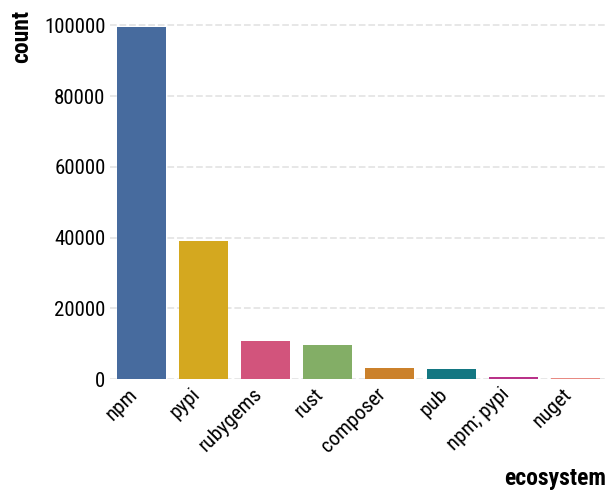

In [5]:
# Count plot of package manager
ecosystem_counts = (
    lazy_frame.unique(subset="package_uuid", keep="first")
    .select(pl.col("ecosystem").value_counts(sort=True))
    .collect()
    .unnest("ecosystem")
).top_k(8, by="count")

_ = sns.barplot(
    data=ecosystem_counts,
    x="ecosystem",
    y="count",
    hue="ecosystem",
)
_ = plt.xticks(rotation=45, ha="right")

In [6]:
ecosystem_counts

ecosystem,count
str,u32
"""npm""",99295
"""pypi""",38987
"""rubygems""",10693
"""rust""",9799
"""composer""",3319
"""pub""",2917
"""npm; pypi""",684
"""nuget""",494


### Package Releases by Release Type

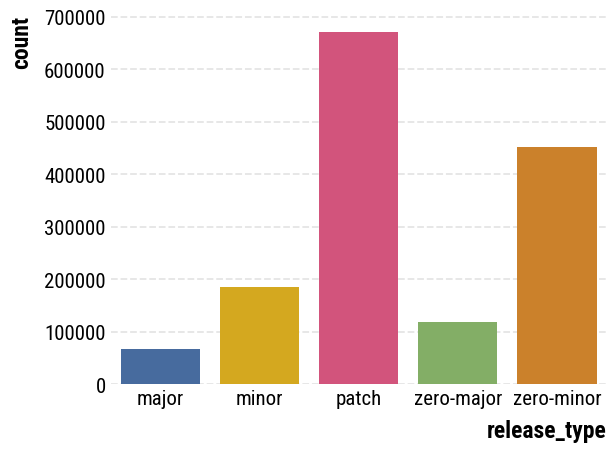

In [7]:
release_type_counts = (
    lazy_frame.filter(pl.col("release_type") != "unknown")
    .select(pl.col("release_type").value_counts())
    .unnest("release_type")
    .sort(by="release_type")
    .collect()
)

# Plot count of release types
_ = sns.barplot(
    data=release_type_counts,
    x="release_type",
    y="count",
    hue="release_type",
)

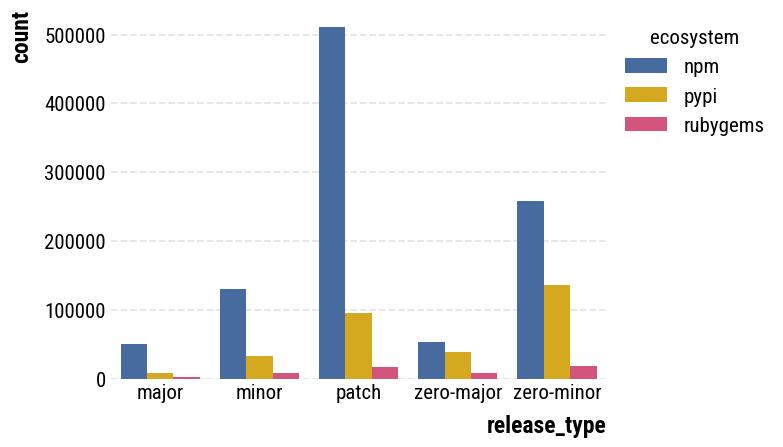

In [8]:
ecosystem_releases_counts = (
    lazy_frame.select(pl.col(["ecosystem", "release_type"]))
    .filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .filter(pl.col("release_type") != "unknown")
    .group_by(pl.all())
    .len(name="count")
    .sort(by=["ecosystem", "release_type"])
    .collect()
)

ax = sns.barplot(
    data=ecosystem_releases_counts,
    x="release_type",
    y="count",
    hue="ecosystem",
    hue_order=["npm", "pypi", "rubygems"],
)

# Move legend outside of plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Distribution of Release Day Dependent Counts by Ecosystem

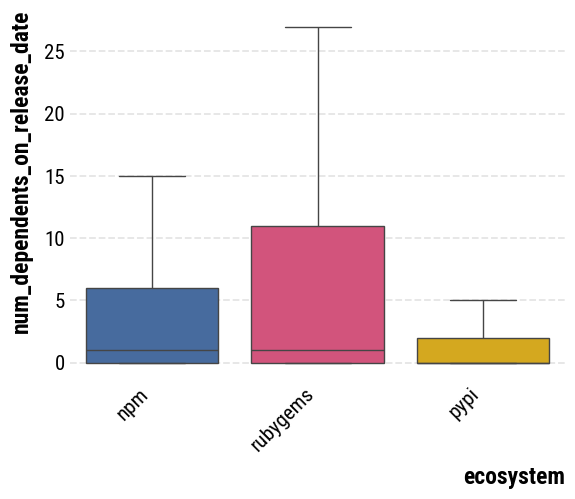

In [9]:
sns.boxplot(
    data=lazy_frame.select(
        pl.col("ecosystem"),
        pl.col("num_dependents_on_release_date"),
    )
    .filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .collect(),
    x="ecosystem",
    y="num_dependents_on_release_date",
    hue="ecosystem",
    hue_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

_ = plt.xticks(rotation=45, ha="right")

In [10]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_dependents_on_release_date"),
).group_by(pl.col("ecosystem"),).quantile(0.5).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_dependents_on_release_date", descending=True
)

ecosystem,num_dependents_on_release_date
str,f64
"""rubygems""",1.0
"""npm""",1.0
"""pypi""",0.0


In [11]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_dependents_on_release_date"),
).group_by(pl.col("ecosystem"),).quantile(0.75).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_dependents_on_release_date", descending=True
)

ecosystem,num_dependents_on_release_date
str,f64
"""rubygems""",11.0
"""npm""",6.0
"""pypi""",2.0


### Distribution of Release Day Star Counts by Release Type

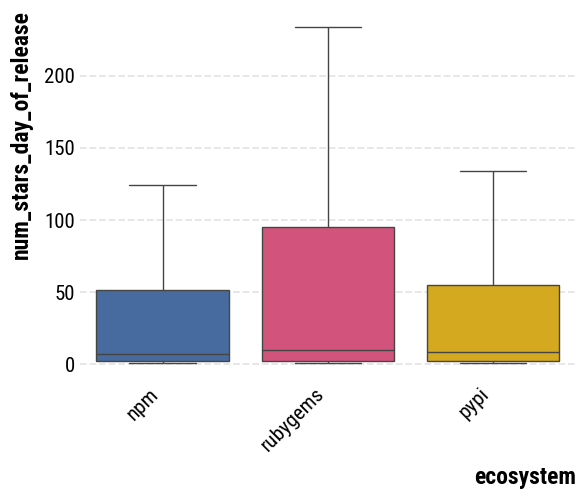

In [12]:
sns.boxplot(
    data=lazy_frame.select(
        pl.col("ecosystem"),
        pl.col("num_stars_day_of_release"),
    )
    .filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .collect(),
    x="ecosystem",
    y="num_stars_day_of_release",
    hue="ecosystem",
    hue_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

_ = plt.xticks(rotation=45, ha="right")

In [13]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_stars_day_of_release"),
).group_by(
    pl.col("ecosystem"),
).quantile(0.10).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_stars_day_of_release", descending=True
)

ecosystem,num_stars_day_of_release
str,f64
"""rubygems""",1.0
"""npm""",1.0
"""pypi""",1.0


In [14]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_stars_day_of_release"),
).group_by(
    pl.col("ecosystem"),
).quantile(0.25).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_stars_day_of_release", descending=True
)

ecosystem,num_stars_day_of_release
str,f64
"""npm""",2.0
"""pypi""",2.0
"""rubygems""",2.0


## Look Ahead Metrics

### Stars

#### Setup

In [15]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_stars_" in col_name
]

# Calculate log difference in stars
constructed_exprs = []
for col_name in selected_columns:
    # Ignore the 0 day
    if col_name == "num_stars_day_of_release":
        continue

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                pl.when(pl.col("num_stars_day_of_release").gt(pl.lit(0)))
                .then(
                    (pl.col(col_name).log() - pl.col("num_stars_day_of_release").log())
                )
                .otherwise(
                    pl.lit(0),
                )
            ).alias(f"log_difference_stars_{timedelta_int}_days")
        )

# Create new column for log difference stars
log_diff_stars_ecosystem_release_type = (
    lazy_frame.filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .filter(pl.col("release_type") != "unknown")
    .filter(pl.col("num_stars_day_of_release").gt(pl.lit(1)))
    .select(
        pl.col("package_uuid"),
        pl.col("package_version"),
        pl.col("package_major_version"),
        pl.col("ecosystem"),
        pl.col("release_type"),
        # Quantile bins for num_stars
        pl.col("num_stars_day_of_release")
        .qcut(
            [0.25, 0.75],
            labels=["bottom-25", "middle-50", "top-25"],
        )
        .over("ecosystem")
        .alias("num_stars_quantile"),
        # Version series bins
        pl.when(
            pl.col("release_type").is_in(["zero-major", "zero-minor"]),
        )
        .then(pl.lit("zero-ver"))
        .when(
            pl.col("package_major_version").eq(pl.lit(1)),
        )
        .then(pl.lit("one-ver"))
        .otherwise(pl.lit("two-plus-ver"))
        .alias("version_series"),
        *constructed_exprs,
    )
    .unpivot(
        index=[
            "package_uuid",
            "ecosystem",
            "release_type",
            "package_version",
            "package_major_version",
            "num_stars_quantile",
            "version_series",
        ],
        variable_name="days_since_release",
        value_name="log_difference_stars",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(
            r"^(log_difference_stars_)(\d+)(_days)$",
            r"$2",
        )
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

#### Log Difference in Stars by Ecosystem and Initial Popularity

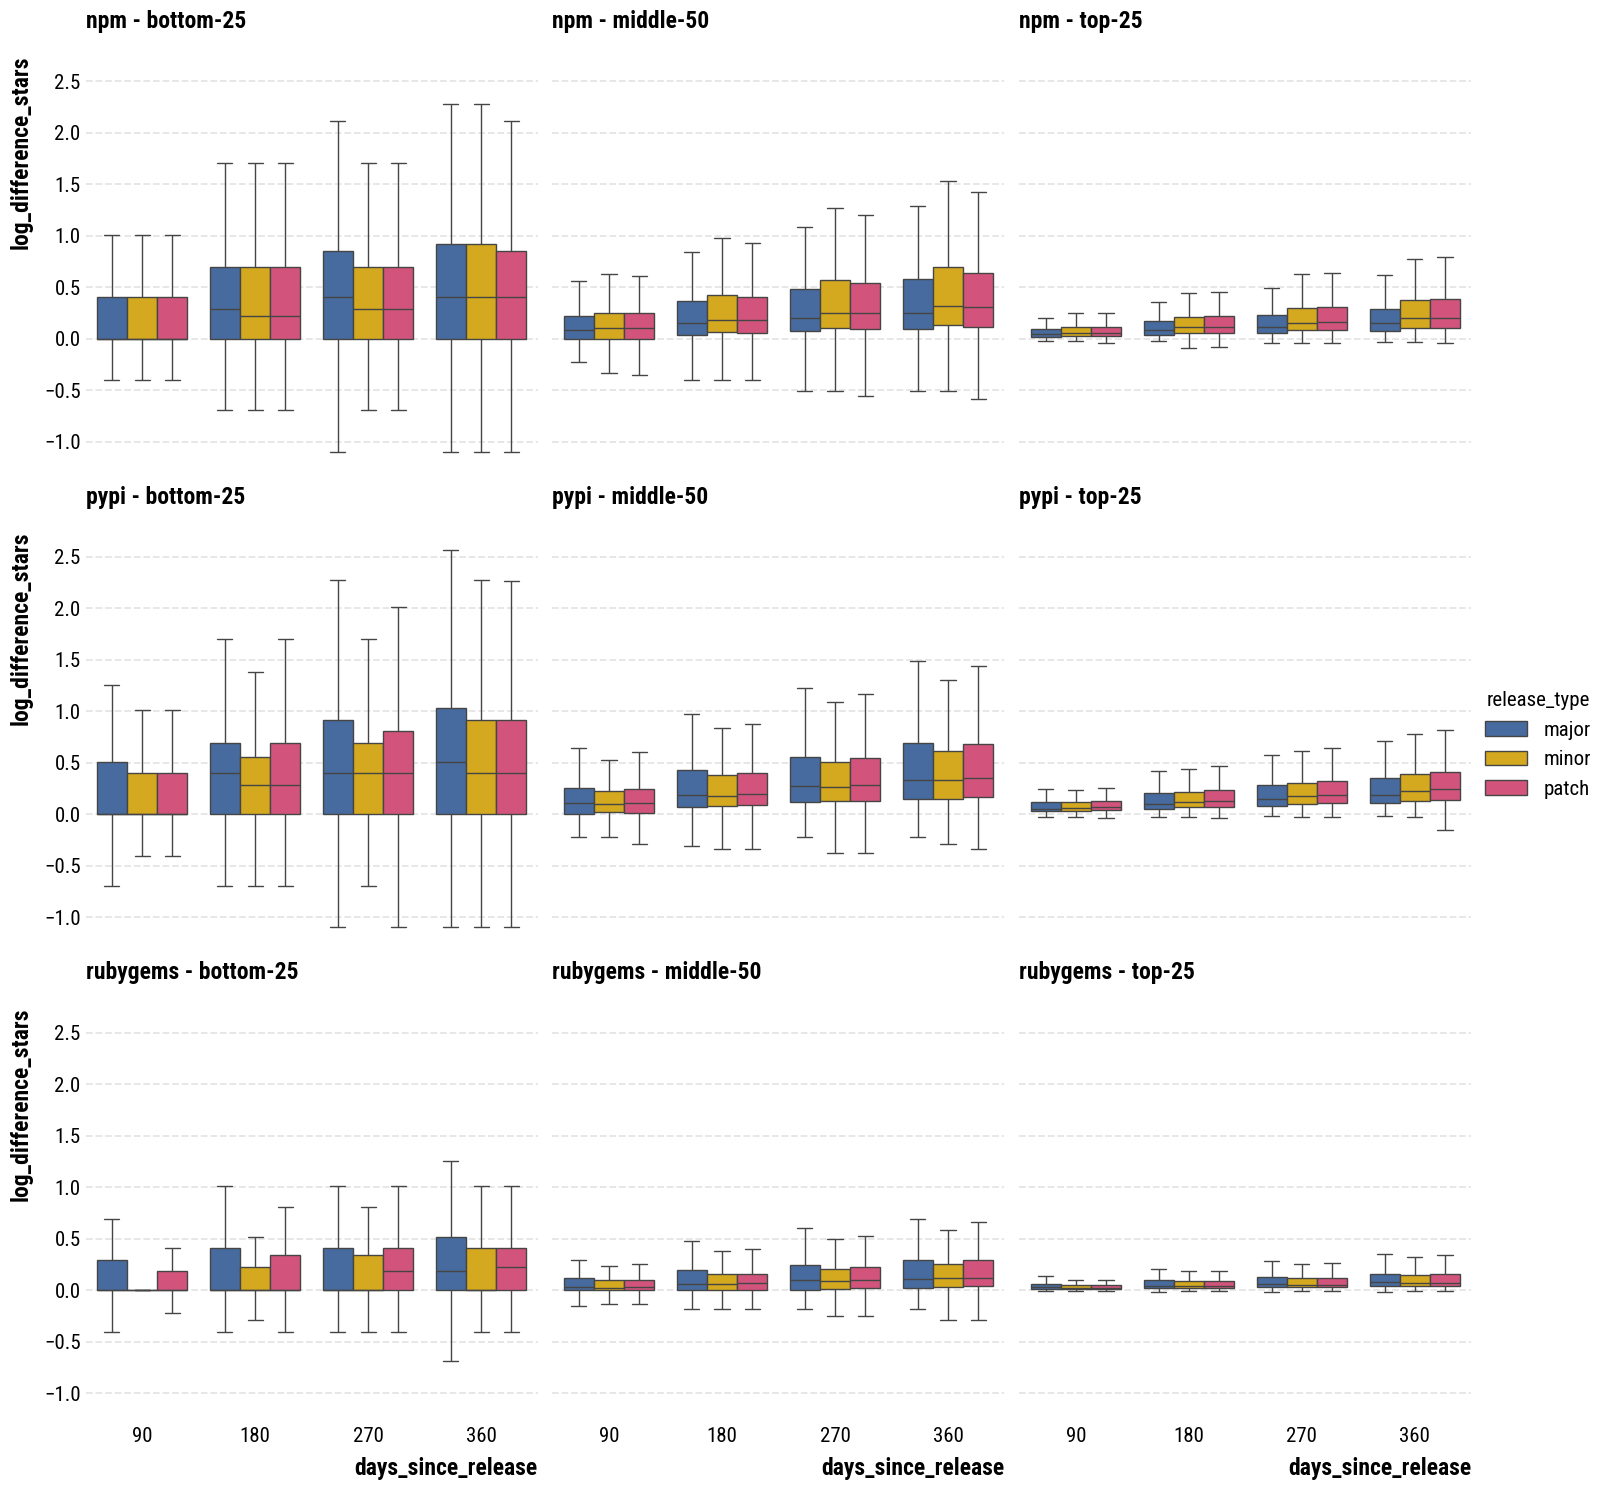

In [16]:
# Plot log difference stars
g = sns.catplot(
    data=log_diff_stars_ecosystem_release_type,
    x="days_since_release",
    y="log_difference_stars",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="num_stars_quantile",
    col_order=["bottom-25", "middle-50", "top-25"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

#### Log Difference in Stars by Ecosystem and Release Series

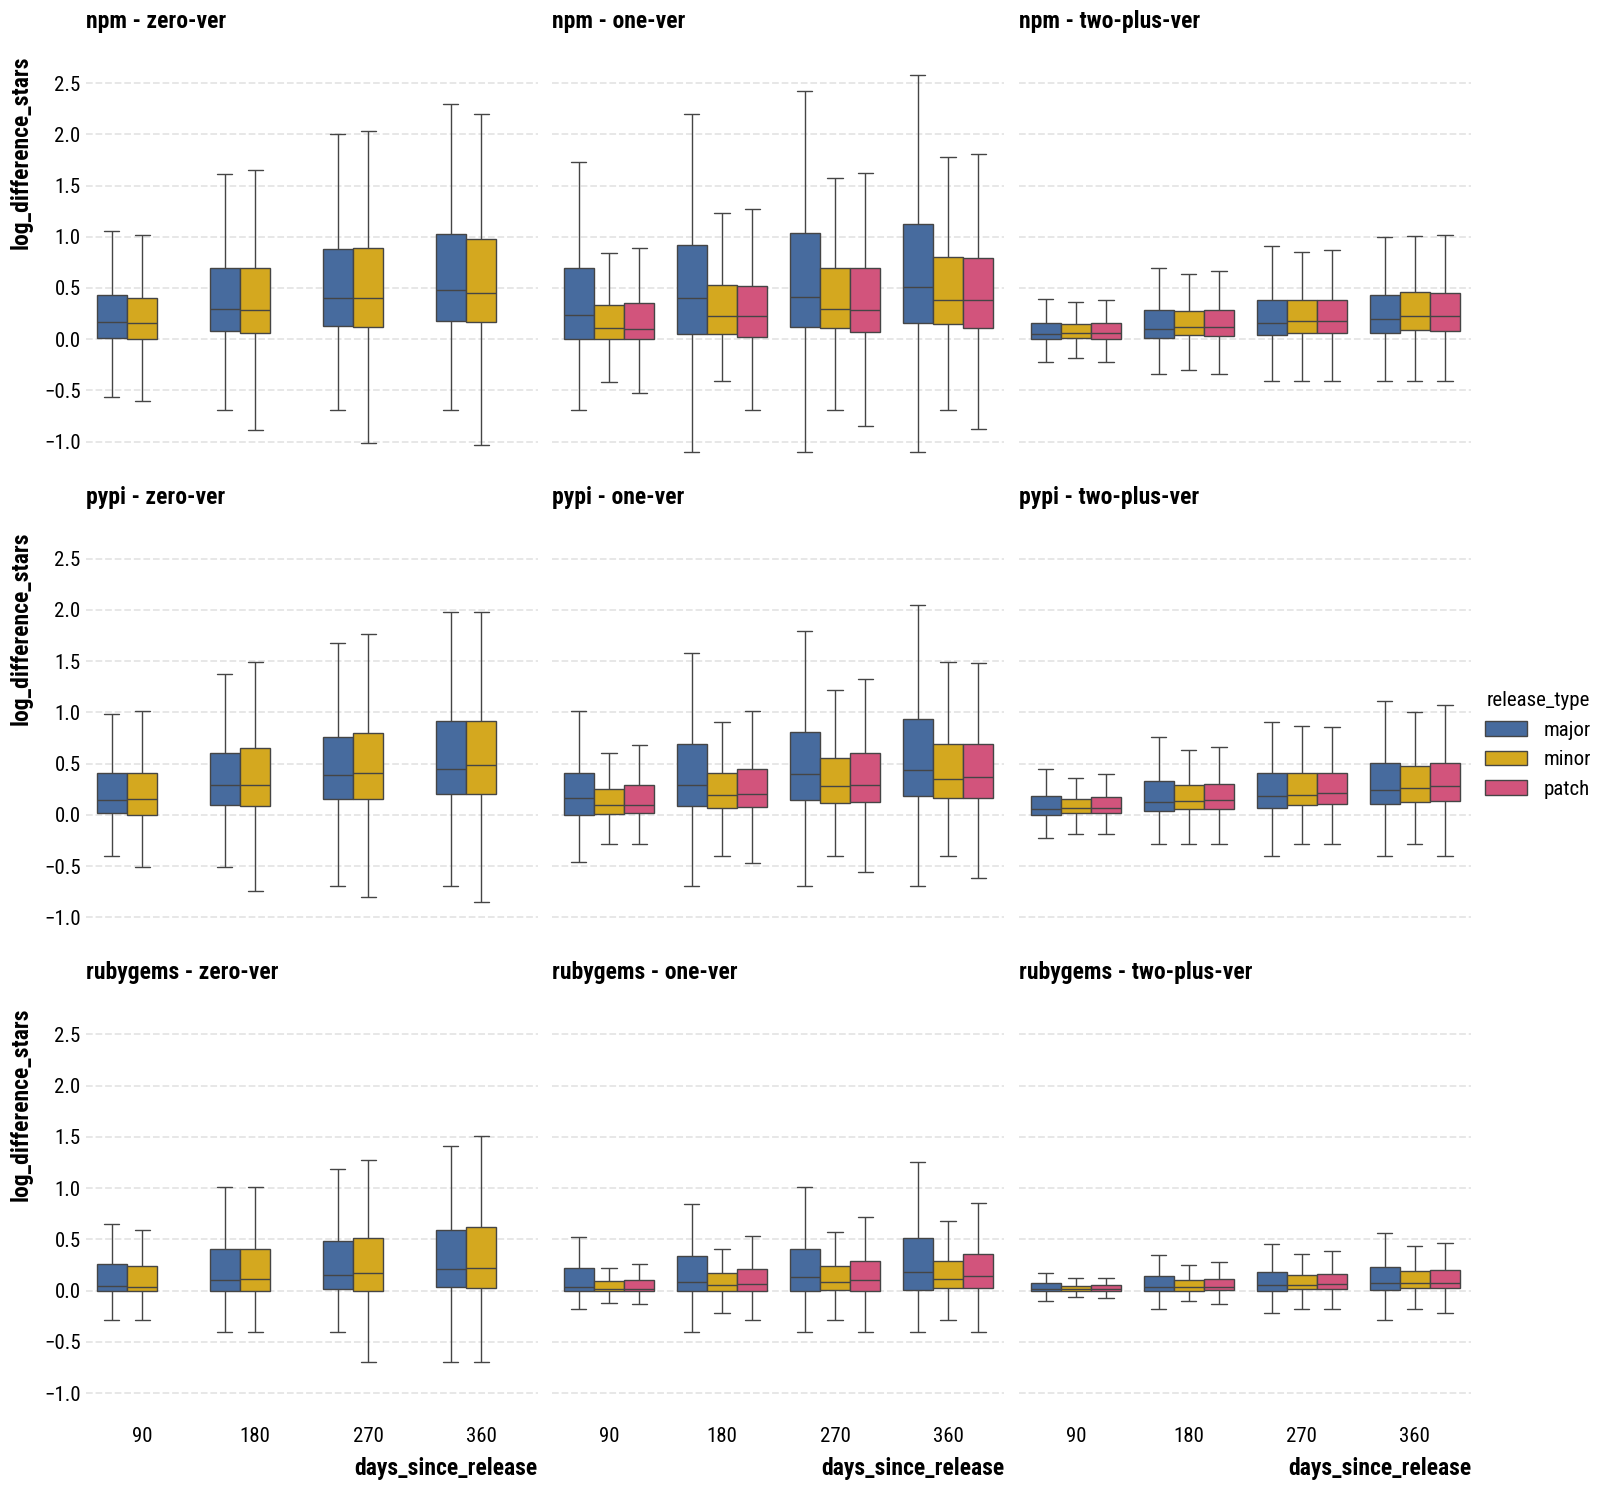

In [17]:
# Last step is to replace zero-major and zero-minor specifically for this plot
log_diff_stars_ecosystem_release_type_replaced_zero_ver = (
    log_diff_stars_ecosystem_release_type.select(
        pl.all().exclude("release_type"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
    )
)


# Plot log difference stars
g = sns.catplot(
    data=log_diff_stars_ecosystem_release_type_replaced_zero_ver,
    x="days_since_release",
    y="log_difference_stars",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="version_series",
    col_order=["zero-ver", "one-ver", "two-plus-ver"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

### Dependents

#### Setup

In [18]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_dependents_" in col_name
]

# Calculate log difference in dependents
constructed_exprs = []
for col_name in selected_columns:
    # Ignore the 0 day
    if col_name == "num_dependents_on_release_date":
        continue

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                pl.when(pl.col("num_dependents_on_release_date").gt(pl.lit(0)))
                .then(
                    (
                        pl.col(col_name).log()
                        - pl.col("num_dependents_on_release_date").log()
                    )
                )
                .otherwise(
                    pl.lit(0),
                )
            ).alias(f"log_difference_dependents_{timedelta_int}_days")
        )

# Create new column for log difference dependents
log_diff_dependents_ecosystem_release_type = (
    lazy_frame.filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .filter(pl.col("release_type") != "unknown")
    .filter(
        pl.col("num_dependents_on_release_date").ge(pl.lit(5)),
    )
    .select(
        pl.col("package_uuid"),
        pl.col("package_version"),
        pl.col("package_major_version"),
        pl.col("ecosystem"),
        pl.col("release_type"),
        pl.col("num_dependents_on_release_date"),
        # Log bin of dependents
        pl.when(
            pl.col("num_dependents_on_release_date").lt(pl.lit(1e2))
        ).then(
            pl.lit("small")
        )
        .when(
            pl.col("num_dependents_on_release_date").lt(pl.lit(1e3))
        ).then(
            pl.lit("medium")
            )
        .when(
            pl.col("num_dependents_on_release_date").lt(pl.lit(1e4))
        ).then(
            pl.lit("large")
        )
        .otherwise(pl.lit("huge"))
        .alias("num_dependents_bin"),
        # Version series bins
        pl.when(
            pl.col("release_type").is_in(["zero-major", "zero-minor"]),
        )
        .then(pl.lit("zero-ver"))
        .when(
            pl.col("package_major_version").eq(pl.lit(1)),
        )
        .then(pl.lit("one-ver"))
        .otherwise(pl.lit("two-plus-ver"))
        .alias("version_series"),
        *constructed_exprs,
    )
    .unpivot(
        index=[
            "package_uuid",
            "ecosystem",
            "release_type",
            "package_version",
            "package_major_version",
            "num_dependents_on_release_date",
            "num_dependents_bin",
            "version_series",
        ],
        variable_name="days_since_release",
        value_name="log_difference_dependents",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(
            r"^(log_difference_dependents_)(\d+)(_days)$",
            r"$2",
        )
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

print(
    log_diff_dependents_ecosystem_release_type.select(
        pl.col("package_uuid").n_unique()
    ).item()
)

33236


In [19]:
log_diff_dependents_ecosystem_release_type.unique(["package_uuid", "package_version"]).shape

(356220, 10)

In [20]:
log_diff_dependents_ecosystem_release_type.group_by("num_dependents_bin").agg(
    pl.col("num_dependents_on_release_date").count().alias("count"),
    pl.col("num_dependents_on_release_date").min().alias("min"),
    pl.col("num_dependents_on_release_date").median().alias("median"),
    pl.col("num_dependents_on_release_date").max().alias("max"),
    pl.col("num_dependents_on_release_date").mean().alias("mean"),
    pl.col("num_dependents_on_release_date").std().alias("std"),
)

num_dependents_bin,count,min,median,max,mean,std
str,u32,i64,f64,i64,f64,f64
"""huge""",67588,10000,48846.0,1844330,175833.909096,258891.668375
"""large""",109324,1000,2558.0,9999,3386.906333,2330.405017
"""small""",995832,5,14.0,99,23.581443,22.519772
"""medium""",252136,100,244.0,999,329.351033,228.53743


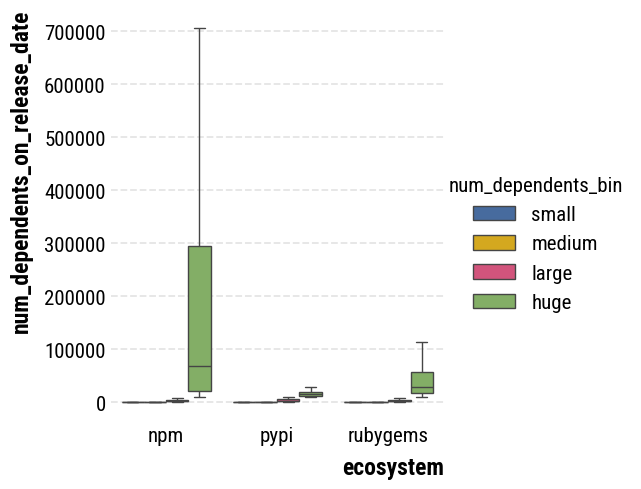

In [21]:
sns.catplot(
    data=log_diff_dependents_ecosystem_release_type,
    x="ecosystem",
    y="num_dependents_on_release_date",
    hue="num_dependents_bin",
    hue_order=["small", "medium", "large", "huge"],
    kind="box",
    showfliers=False,
)

#### ANOVA of Log Difference in Dependents by Ecosystem at One Year

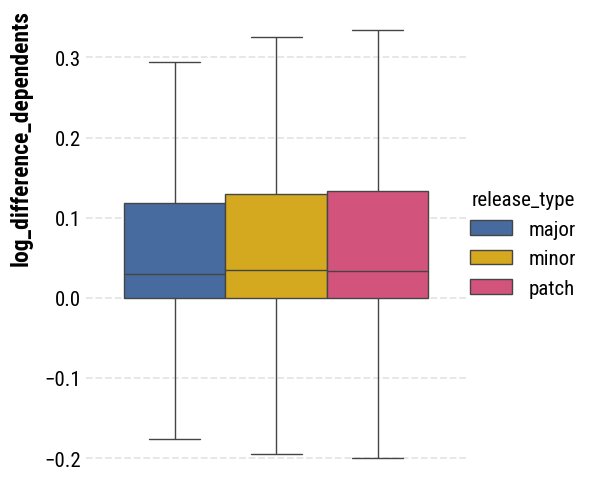

In [22]:
anova_data = (
    log_diff_dependents_ecosystem_release_type.filter(
        pl.col("log_difference_dependents").is_null().not_()
    )
    .filter(pl.col("log_difference_dependents").is_infinite().not_())
    .filter(pl.col("days_since_release").eq(pl.lit(360)))
)

# Plot log difference dependents
g = sns.catplot(
    data=anova_data,
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    # col="ecosystem",
    # col_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

# g.set_titles("{col_name}")

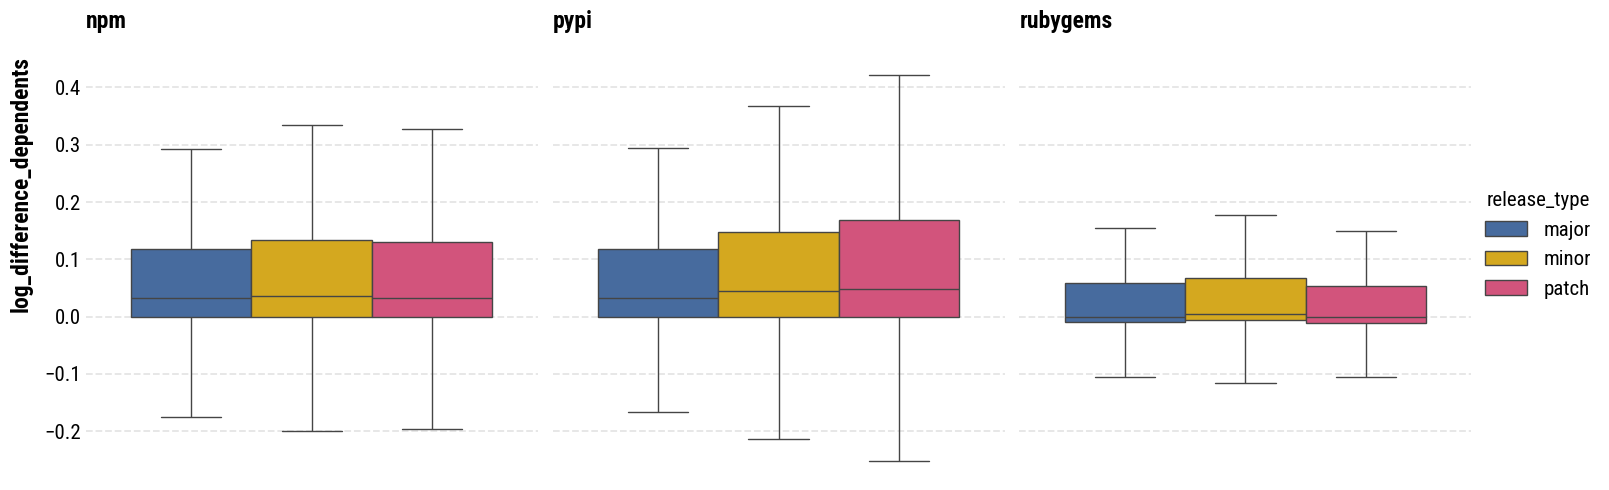

In [23]:
# Plot log difference dependents
g = sns.catplot(
    data=anova_data,
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    col="ecosystem",
    col_order=["npm", "pypi", "rubygems"],
    kind="box",
    showfliers=False,
    # kind="violin",
    # cut=0,
)

g.set_titles("{col_name}")

In [24]:
# Get the average increase in dependents for each ecosystem at the one-year mark
# Break this out by release type
# I.e. columns should be: release type, ecosystem, average increase in dependents
avg_increase_dependents = (
    anova_data.group_by(["ecosystem", "release_type"])
    .agg(
        pl.col("log_difference_dependents").mean().alias("avg_increase_dependents")
    )
    .sort(by=["ecosystem", "release_type"])
)
# pivot on ecosystem
avg_increase_dependents.pivot(
    index="release_type",
    on="ecosystem",
    values="avg_increase_dependents",
).sort(by="release_type")

release_type,npm,pypi,rubygems
str,f64,f64,f64
"""major""",0.100803,0.072293,0.069627
"""minor""",0.107281,0.087462,0.063797
"""patch""",0.10167,0.104402,0.052376
"""zero-major""",0.219123,0.100599,0.124694
"""zero-minor""",0.204094,0.086433,0.150361


In [25]:
# One way ANOVA for ecosystem
for ecosystem in ["npm", "pypi", "rubygems"]:
    print(f"ECOSYSTEM: {ecosystem}")
    distributions = {
        release_type: anova_data.filter(pl.col("ecosystem").eq(pl.lit(ecosystem)))
        .filter(pl.col("release_type").eq(pl.lit(release_type)))
        .get_column("log_difference_dependents")
        .to_numpy()
        for release_type in ["major", "minor", "patch"]
    }

    result = f_oneway(*distributions.values())
    print(result)

    if result.pvalue < 0.05:
        print("Distributions are significantly different")
        print()

        # Conduct pairwise t-tests
        for release_type1, release_type2 in combinations(distributions.keys(), 2):
            post_hoc_result = ttest_ind(
                distributions[release_type1],
                distributions[release_type2],
            )

            if post_hoc_result.pvalue < 0.05:
                print(release_type1, release_type2, post_hoc_result)
                print(
                    release_type1,
                    round(distributions[release_type1].mean(), 3),
                    round(distributions[release_type1].std(), 3),
                    len(distributions[release_type1]),
                )
                print(
                    release_type2,
                    round(distributions[release_type2].mean(), 3),
                    round(distributions[release_type2].std(), 3),
                    len(distributions[release_type2]),
                )
            else:
                print(
                    f"{release_type1} and {release_type2} are not significantly different"
                )

            print()


    print()
    print("-" * 80)

ECOSYSTEM: npm
F_onewayResult(statistic=np.float64(5.888694306384211), pvalue=np.float64(0.0027710114963005674))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(-2.2040631911153414), pvalue=np.float64(0.027523151602229925), df=np.float64(69811.0))
major 0.101 0.37 16681
minor 0.107 0.318 53132

major and patch are not significantly different

minor patch TtestResult(statistic=np.float64(3.3548829192460916), pvalue=np.float64(0.0007941247848378115), df=np.float64(212289.0))
minor 0.107 0.318 53132
patch 0.102 0.339 159159


--------------------------------------------------------------------------------
ECOSYSTEM: pypi
F_onewayResult(statistic=np.float64(27.757301842290218), pvalue=np.float64(9.006880150376448e-13))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(-2.677069310982333), pvalue=np.float64(0.007438005469330653), df=np.float64(10940.0))
major 0.072 0.209 1761
minor 0.087 0.219 9181

major patch Tt

In [26]:
results = {}

def compute_anova_and_post_hocs_for_ecosystem(
    data: pl.DataFrame,
    ecosystem: str,
) -> None:
    for group in data.select("num_dependents_bin").unique()["num_dependents_bin"]:
        # One way ANOVA for ecosystem and group
        distributions = {
            release_type: data.filter(pl.col("ecosystem").eq(pl.lit(ecosystem)))
            .filter(pl.col("release_type").eq(pl.lit(release_type)))
            .filter(pl.col("num_dependents_bin").eq(pl.lit(group)))
            .select(pl.col("log_difference_dependents"))
            .get_column("log_difference_dependents")
            .to_numpy()
            for release_type in ["major", "minor", "patch"]
        }

        overall_group_result = f_oneway(*distributions.values())
        if overall_group_result.pvalue < 0.05:
            overall_group_result_str = "+"
        else:
            overall_group_result_str = ""

        group_results_key = f"{group}{overall_group_result_str}"

        # Conduct pairwise t-tests
        for release_type1, release_type2 in combinations(distributions.keys(), 2):
            post_hoc_result = ttest_ind(
                distributions[release_type1],
                distributions[release_type2],
            )

            # Calc means, stds, and counts
            dist_1_mean = round(distributions[release_type1].mean(), 3)
            dist_1_std = round(distributions[release_type1].std(), 3)
            dist_1_count = len(distributions[release_type1])
            dist_2_mean = round(distributions[release_type2].mean(), 3)
            dist_2_std = round(distributions[release_type2].std(), 3)
            dist_2_count = len(distributions[release_type2])

            if release_type1 == "major" and release_type2 == "minor":
                significant_str = "*"
            elif release_type1 == "major" and release_type2 == "patch":
                significant_str = "^"
            elif release_type1 == "minor" and release_type2 == "patch":
                significant_str = "#"

            if post_hoc_result.pvalue < 0.05:
                post_hoc_result_str = f" {significant_str}"
            else:
                post_hoc_result_str = ""

            # Setup results
            if ecosystem not in results:
                results[ecosystem] = {}
            if group_results_key not in results[ecosystem]:
                results[ecosystem][group_results_key] = {}

            # Store results
            if release_type1 not in results[ecosystem][group_results_key]:
                results[ecosystem][group_results_key][release_type1] = (
                    f"{dist_1_mean}±{dist_1_std} ({dist_1_count}){post_hoc_result_str}"
                )
            else:
                results[ecosystem][group_results_key][release_type1] += (
                    f"{post_hoc_result_str}"
                )
        
            # Store results
            if release_type2 not in results[ecosystem][group_results_key]:
                results[ecosystem][group_results_key][release_type2] = (
                    f"{dist_2_mean}±{dist_2_std} ({dist_2_count}){post_hoc_result_str}"
                )
            else:
                results[ecosystem][group_results_key][release_type2] += (
                    f"{post_hoc_result_str}"
                )

# Compute ANOVA and post hocs for each ecosystem
for ecosystem in ["npm", "pypi", "rubygems"]:
    compute_anova_and_post_hocs_for_ecosystem(
        data=anova_data,
        ecosystem=ecosystem,
    )

# Unpack to table of results
# columns are:
#  - ecosystem
#  - group
#  - major
#  - minor
#  - patch
results_table = []
for ecosystem, groups in results.items():
    for group, release_types in groups.items():
        row = {
            "ecosystem": ecosystem,
            "group": group,
        }
        row.update(release_types)
        results_table.append(row)

results_table_df = pl.DataFrame(results_table)
results_table_df

ecosystem,group,major,minor,patch
str,str,str,str,str
"""npm""","""small+""","""0.104±0.422 (10225) *""","""0.12±0.368 (32397) * #""","""0.107±0.384 (108350) #"""
"""npm""","""huge""","""0.042±0.073 (1486)""","""0.044±0.098 (3302)""","""0.044±0.094 (8621)"""
"""npm""","""medium+""","""0.117±0.336 (3255) * ^""","""0.103±0.253 (11742) *""","""0.103±0.246 (29236) ^"""
"""npm""","""large+""","""0.104±0.209 (1715) * ^""","""0.081±0.176 (5691) * #""","""0.09±0.18 (12952) ^ #"""
"""pypi""","""huge+""","""0.043±0.039 (24) ^""","""0.044±0.038 (120) #""","""0.033±0.017 (1238) ^ #"""
…,…,…,…,…
"""pypi""","""small+""","""0.07±0.226 (1377) * ^""","""0.088±0.242 (6939) * #""","""0.114±0.273 (19251) ^ #"""
"""rubygems""","""small+""","""0.087±0.399 (676)""","""0.081±0.333 (2509) #""","""0.063±0.315 (5024) #"""
"""rubygems""","""medium""","""0.05±0.168 (199)""","""0.065±0.186 (1055)""","""0.059±0.204 (1835)"""


In [27]:
results_table_df.filter(pl.col("ecosystem").eq(pl.lit("rubygems")))

ecosystem,group,major,minor,patch
str,str,str,str,str
"""rubygems""","""small+""","""0.087±0.399 (676)""","""0.081±0.333 (2509) #""","""0.063±0.315 (5024) #"""
"""rubygems""","""medium""","""0.05±0.168 (199)""","""0.065±0.186 (1055)""","""0.059±0.204 (1835)"""
"""rubygems""","""large+""","""0.012±0.062 (86)""","""0.023±0.067 (617) #""","""0.015±0.046 (898) #"""
"""rubygems""","""huge""","""-0.002±0.017 (38)""","""0.0±0.017 (314)""","""-0.001±0.019 (558)"""


#### Log Difference in Dependents by Package Ecosystem and Initial Utilization

In [28]:
# g = sns.catplot(
#     data=log_diff_dependents_ecosystem_release_type.filter(
#         pl.col("days_since_release").eq(pl.lit(360)),
#         pl.col("release_type").is_in(["major", "minor", "patch"])
#     ),
#     x="release_type",
#     y="log_difference_dependents",
#     hue="release_type",
#     hue_order=["major", "minor", "patch"],
#     col="num_dependents_bin",
#     col_order=["small", "medium", "large", "huge"],
#     kind="box",
#     row="ecosystem",
#     row_order=["npm", "pypi", "rubygems"],
#     showfliers=False,
# )

# g.set_titles("{col_name} - {row_name}")

# Actually we want this as a table
# Columns are "ecosystem", "release_type", "small-mean", "medium-mean", "large-mean", "huge-mean"
# Group by ecosystem and release type, then calculate the mean for each num_dependents_bin
mean_dependents_per_ecosystem_release_type = (
    log_diff_dependents_ecosystem_release_type.filter(
        pl.col("days_since_release").eq(pl.lit(360)),
        pl.col("release_type").is_in(["major", "minor", "patch"]),
        # remove inf and nan values
        pl.col("log_difference_dependents").is_null().not_(),
        pl.col("log_difference_dependents").is_infinite().not_(),
    )
    .group_by(["ecosystem", "release_type", "num_dependents_bin"])
    .agg(
        pl.col("log_difference_dependents").mean().alias("mean_log_difference_dependents"),
        pl.col("log_difference_dependents").std().alias("std_log_difference_dependents"),
    )
    # Create column of rounded mean +- rounded std
    .with_columns(
        (
            pl.col("mean_log_difference_dependents").round(3).cast(pl.String)
            + pl.lit(" ± ")
            + pl.col("std_log_difference_dependents").round(3).cast(pl.String)
        ).alias("mean_std_log_difference_dependents"),
    )
    .pivot(
        index=["ecosystem", "num_dependents_bin"],
        on="release_type",
        values="mean_std_log_difference_dependents",
    )
    .with_columns(
        pl.when(pl.col("num_dependents_bin").eq(pl.lit("small")))
            .then(pl.lit("1 small"))
            .when(pl.col("num_dependents_bin").eq(pl.lit("medium")))
            .then(pl.lit("2 medium"))
            .when(pl.col("num_dependents_bin").eq(pl.lit("large")))
            .then(pl.lit("3 large"))
            .when(pl.col("num_dependents_bin").eq(pl.lit("huge")))
            .then(pl.lit("4 huge"))
            .otherwise(pl.lit("unknown"))
            .alias("num_dependents_bin"),
    )
    .sort(by=["ecosystem", "num_dependents_bin"])
    .select(
        pl.col("ecosystem"),
        pl.col("num_dependents_bin"),
        pl.col("major"),
        pl.col("minor"),
        pl.col("patch"),
        # pl.col("huge"),
    )
)

mean_dependents_per_ecosystem_release_type.filter(pl.col("ecosystem").eq(pl.lit("npm")))

ecosystem,num_dependents_bin,major,minor,patch
str,str,str,str,str
"""npm""","""1 small""","""0.104 ± 0.422""","""0.12 ± 0.368""","""0.107 ± 0.384"""
"""npm""","""2 medium""","""0.117 ± 0.336""","""0.103 ± 0.253""","""0.103 ± 0.246"""
"""npm""","""3 large""","""0.104 ± 0.209""","""0.081 ± 0.176""","""0.09 ± 0.18"""
"""npm""","""4 huge""","""0.042 ± 0.073""","""0.044 ± 0.098""","""0.044 ± 0.094"""


In [29]:
mean_dependents_per_ecosystem_release_type.filter(pl.col("ecosystem").eq(pl.lit("pypi")))

ecosystem,num_dependents_bin,major,minor,patch
str,str,str,str,str
"""pypi""","""1 small""","""0.07 ± 0.226""","""0.088 ± 0.242""","""0.114 ± 0.273"""
"""pypi""","""2 medium""","""0.088 ± 0.144""","""0.092 ± 0.135""","""0.088 ± 0.143"""
"""pypi""","""3 large""","""0.063 ± 0.094""","""0.076 ± 0.107""","""0.069 ± 0.101"""
"""pypi""","""4 huge""","""0.043 ± 0.04""","""0.044 ± 0.038""","""0.033 ± 0.017"""


In [30]:
mean_dependents_per_ecosystem_release_type.filter(pl.col("ecosystem").eq(pl.lit("rubygems")))

ecosystem,num_dependents_bin,major,minor,patch
str,str,str,str,str
"""rubygems""","""1 small""","""0.087 ± 0.399""","""0.081 ± 0.333""","""0.063 ± 0.315"""
"""rubygems""","""2 medium""","""0.05 ± 0.168""","""0.065 ± 0.186""","""0.059 ± 0.204"""
"""rubygems""","""3 large""","""0.012 ± 0.063""","""0.023 ± 0.067""","""0.015 ± 0.046"""
"""rubygems""","""4 huge""","""-0.002 ± 0.017""","""0.0 ± 0.017""","""-0.001 ± 0.019"""


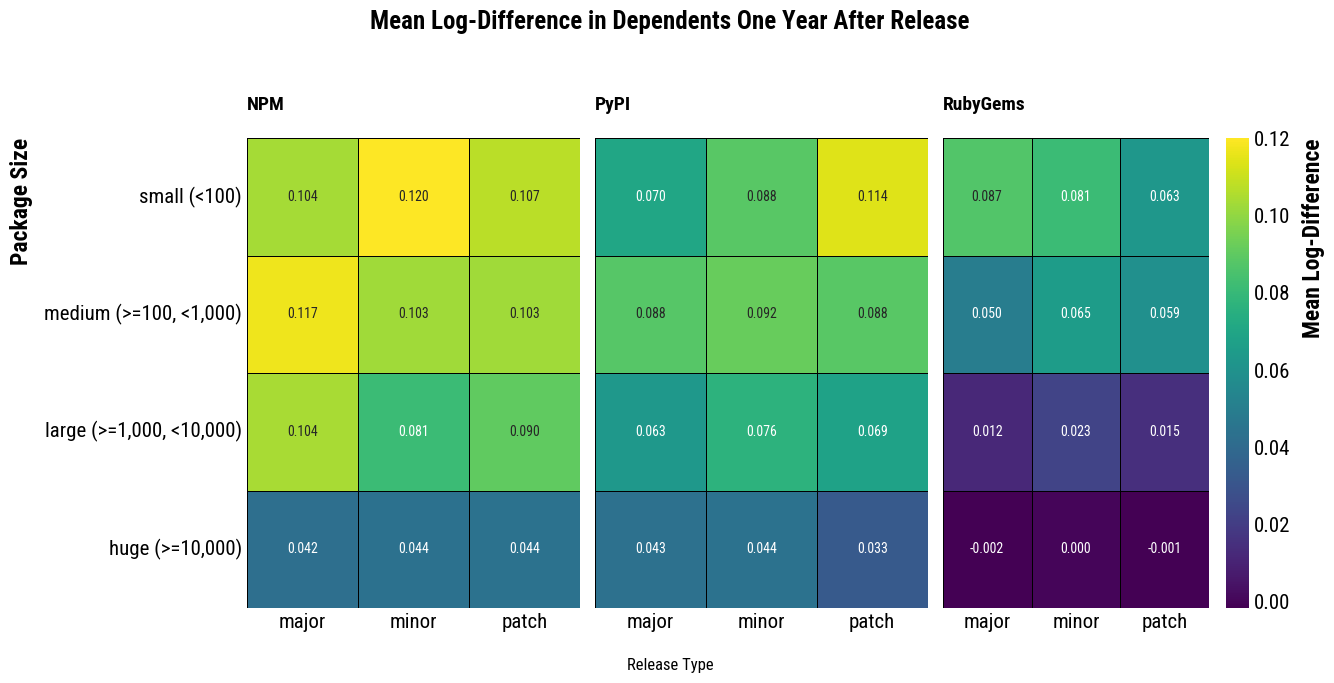

In [31]:
# --- Polars Data Preparation ---
base_data = (
    log_diff_dependents_ecosystem_release_type.filter(
        pl.col("days_since_release").eq(pl.lit(360)),
        pl.col("release_type").is_in(["major", "minor", "patch"]),
        pl.col("log_difference_dependents").is_null().not_(),
        pl.col("log_difference_dependents").is_infinite().not_(),
    )
    .group_by(["ecosystem", "num_dependents_bin", "release_type"])
    .agg(
        pl.col("log_difference_dependents").mean().alias("mean_log_difference_dependents"),
    )
    .with_columns(
        # Assign numeric prefixes and descriptive labels for correct sorting and display
        pl.when(pl.col("num_dependents_bin").eq(pl.lit("small")))
            .then(pl.lit("1 small (<100)"))
            .when(pl.col("num_dependents_bin").eq(pl.lit("medium")))
            .then(pl.lit("2 medium (>=100, <1,000)"))
            .when(pl.col("num_dependents_bin").eq(pl.lit("large")))
            .then(pl.lit("3 large (>=1,000, <10,000)"))
            .when(pl.col("num_dependents_bin").eq(pl.lit("huge")))
            .then(pl.lit("4 huge (>=10,000)"))
            .otherwise(pl.lit("unknown"))
            .alias("num_dependents_bin_display"), # New column for sorted and displayed order
    )
    .sort(by=["ecosystem", "num_dependents_bin_display"]) # Sort by the new column
    .with_columns(
        # remove the numbers from the display column for better readability
        pl.col("num_dependents_bin_display")
        .str.replace(r"^\d+ ", "")
        .alias("num_dependents_bin_display"),
    )
)

# Get unique ecosystems and their display names
ecosystem_map = {
    "npm": "NPM",
    "pypi": "PyPI",
    "rubygems": "RubyGems"
}
ecosystems_sorted = sorted(ecosystem_map.keys()) # Ensure consistent order

# Determine a common color scale range
min_val = base_data["mean_log_difference_dependents"].min()
max_val = base_data["mean_log_difference_dependents"].max()

# --- Heatmap Generation (Subplots) ---
fig, axes = plt.subplots(1, len(ecosystems_sorted), figsize=(4.5 * len(ecosystems_sorted), 6.5), sharey=True)

if len(ecosystems_sorted) == 1:
    axes = [axes] # Ensure axes is iterable even if only one subplot

for i, ecosystem_key in enumerate(ecosystems_sorted):
    ecosystem_display_name = ecosystem_map[ecosystem_key]

    # Filter data for the current ecosystem
    current_ecosystem_data = base_data.filter(pl.col("ecosystem").eq(ecosystem_key))

    # Pivot for the heatmap
    heatmap_df = (
        current_ecosystem_data.pivot(
            index="num_dependents_bin_display", # Use the sorted display column as index
            on="release_type",
            values="mean_log_difference_dependents",
        )
        .select(["num_dependents_bin_display", "major", "minor", "patch"]) # Ensure column order
        .to_pandas()
    )
    heatmap_df = heatmap_df.set_index("num_dependents_bin_display")

    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=.5,
        linecolor="black",
        cbar=True if i == len(ecosystems_sorted) - 1 else False,
        ax=axes[i],
        vmin=min_val,
        vmax=max_val,
        cbar_kws={'label': 'Mean Log-Difference'}
    )
    axes[i].set_title(ecosystem_display_name, fontsize=14) # Smaller title font
    axes[i].set_xlabel('') # Remove individual x-labels
    if i == 0:
        axes[i].set_ylabel('Package Size')
    else:
        axes[i].set_ylabel('')
    axes[i].tick_params(axis='y', rotation=0)

# Overall Title
plt.suptitle('Mean Log-Difference in Dependents One Year After Release', y=1.03, fontsize=18, weight='bold') # Bigger, bold title

# Overall X-axis label, positioned manually for "left-alignment" look
fig.text(0.5, 0.01, 'Release Type', ha='center', va='bottom', fontsize=12) # Adjust x,y for positioning

plt.tight_layout(rect=[0, 0.05, 1, 0.98]) # Adjust layout to make room for suptitle and overall xlabel
plt.show()

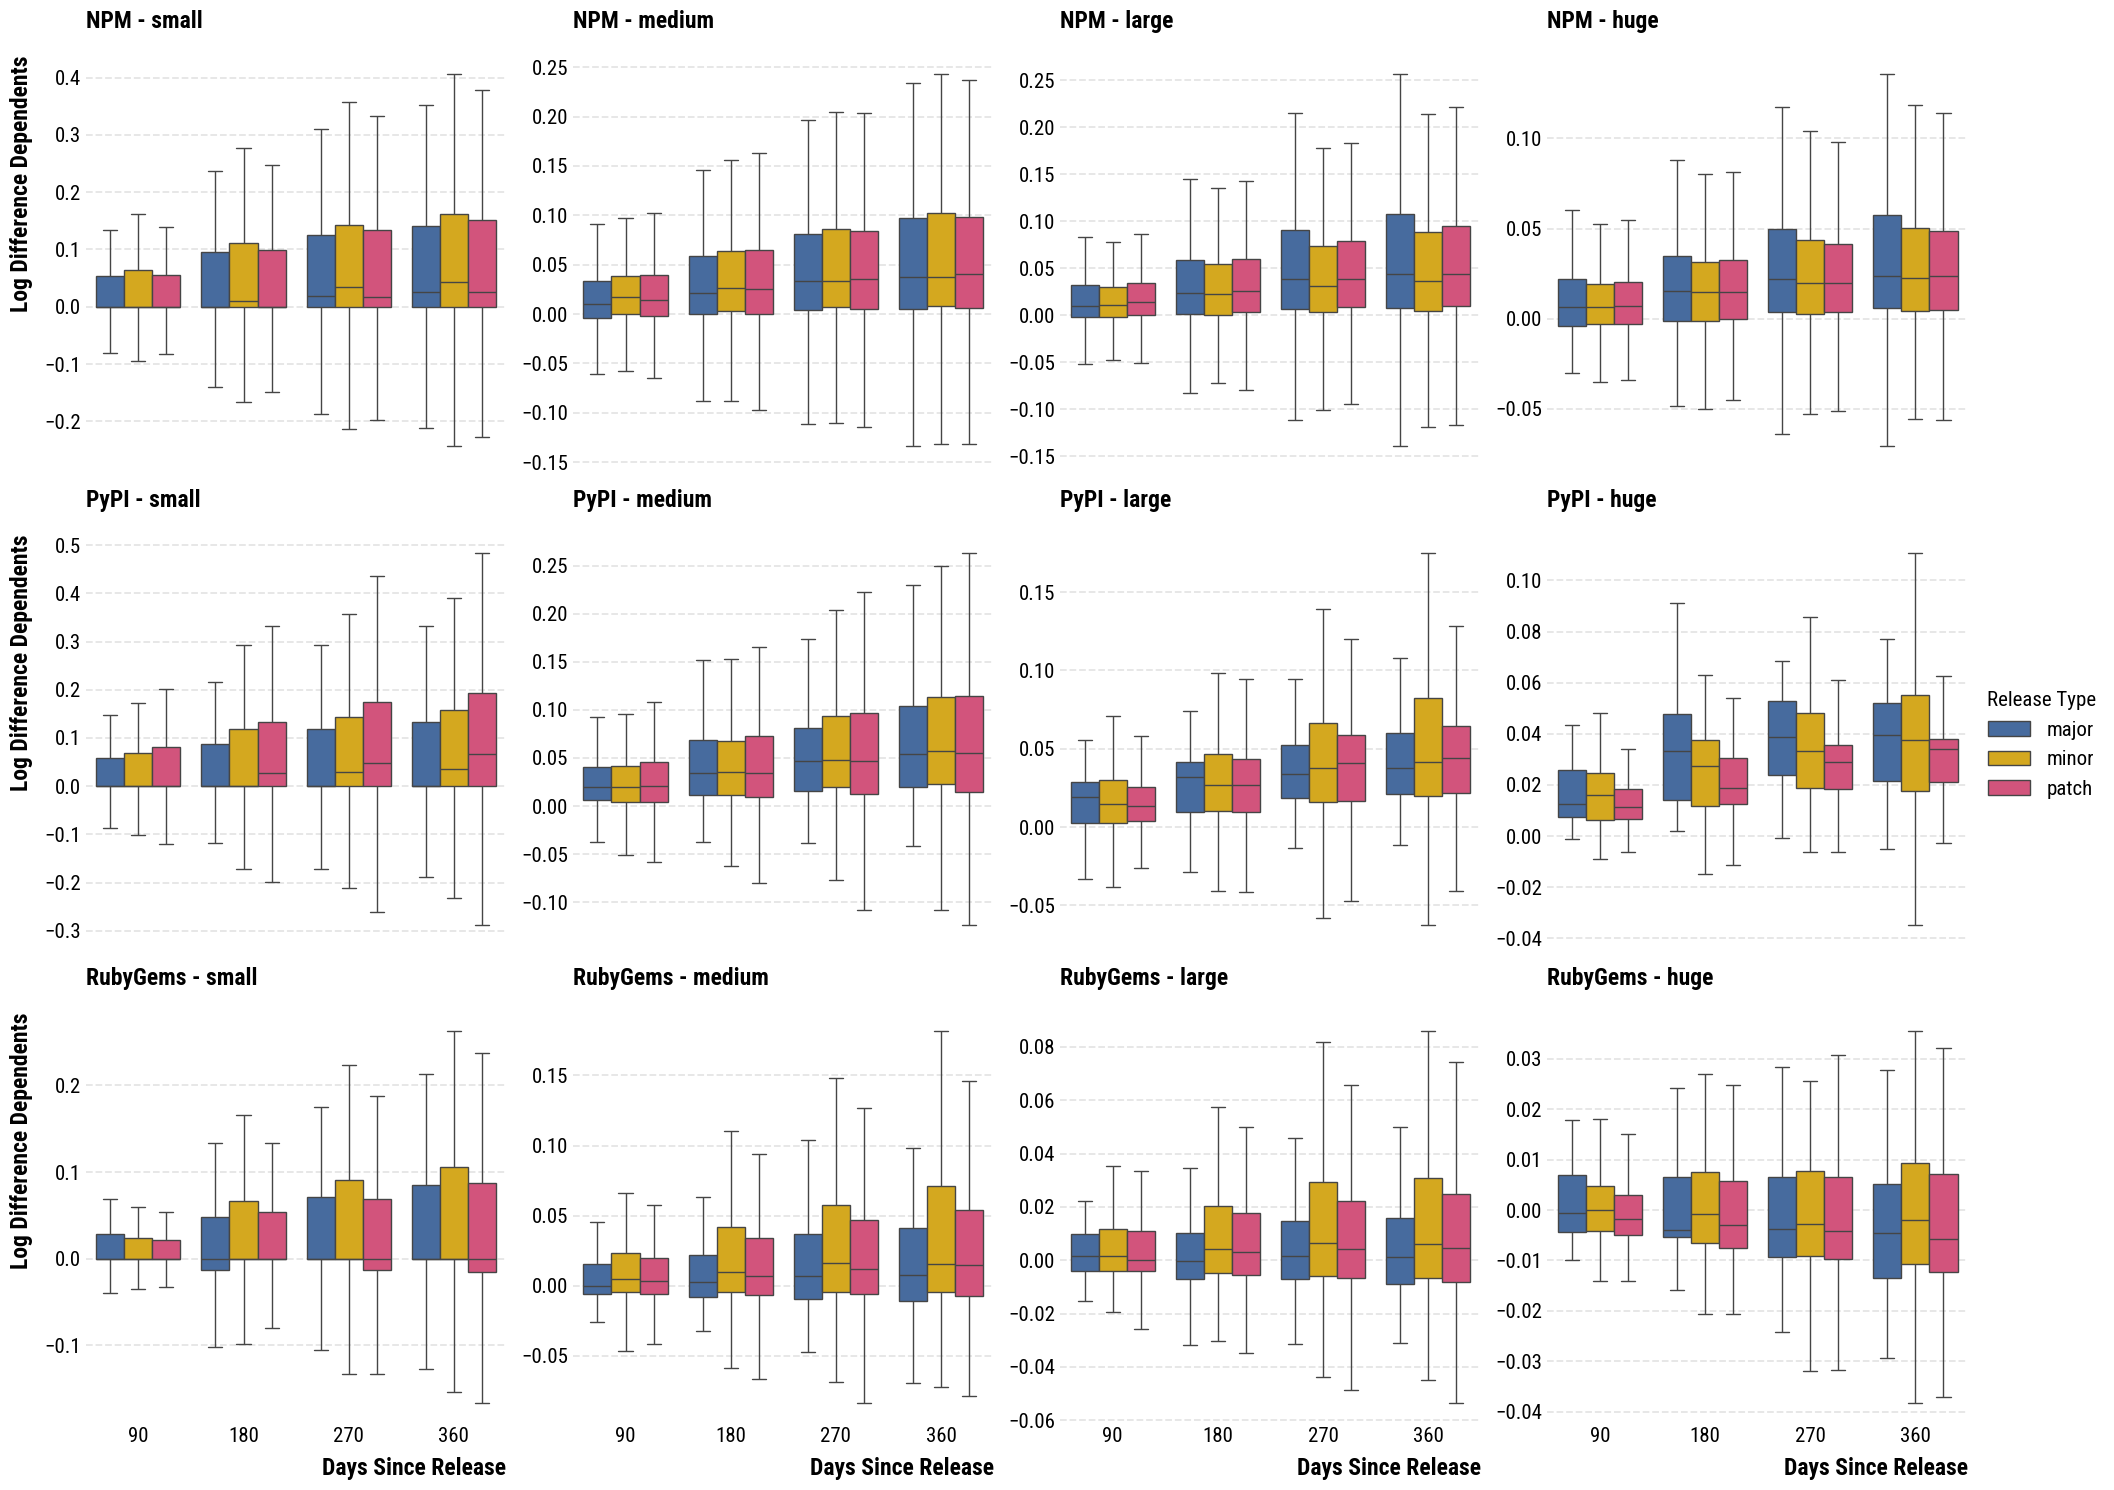

In [32]:
# Plot log difference dependents
g = sns.catplot(
    data=log_diff_dependents_ecosystem_release_type.with_columns(
        pl.col("log_difference_dependents").alias("Log Difference Dependents"),
        pl.col("days_since_release").alias("Days Since Release"),
        pl.col("release_type").alias("Release Type"),
        pl.when(pl.col("ecosystem").eq(pl.lit("npm")))
        .then(pl.lit("NPM"))
        .when(pl.col("ecosystem").eq(pl.lit("pypi")))
        .then(pl.lit("PyPI"))
        .when(pl.col("ecosystem").eq(pl.lit("rubygems")))
        .then(pl.lit("RubyGems"))
        .otherwise(pl.lit("Unknown Ecosystem"))
        .alias("ecosystem"),
    ),
    x="Days Since Release",
    y="Log Difference Dependents",
    hue="Release Type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["NPM", "PyPI", "RubyGems"],
    col="num_dependents_bin",
    col_order=["small", "medium", "large", "huge"],
    showfliers=False,
    sharey=False,
)

g.set_titles("{row_name} - {col_name}")

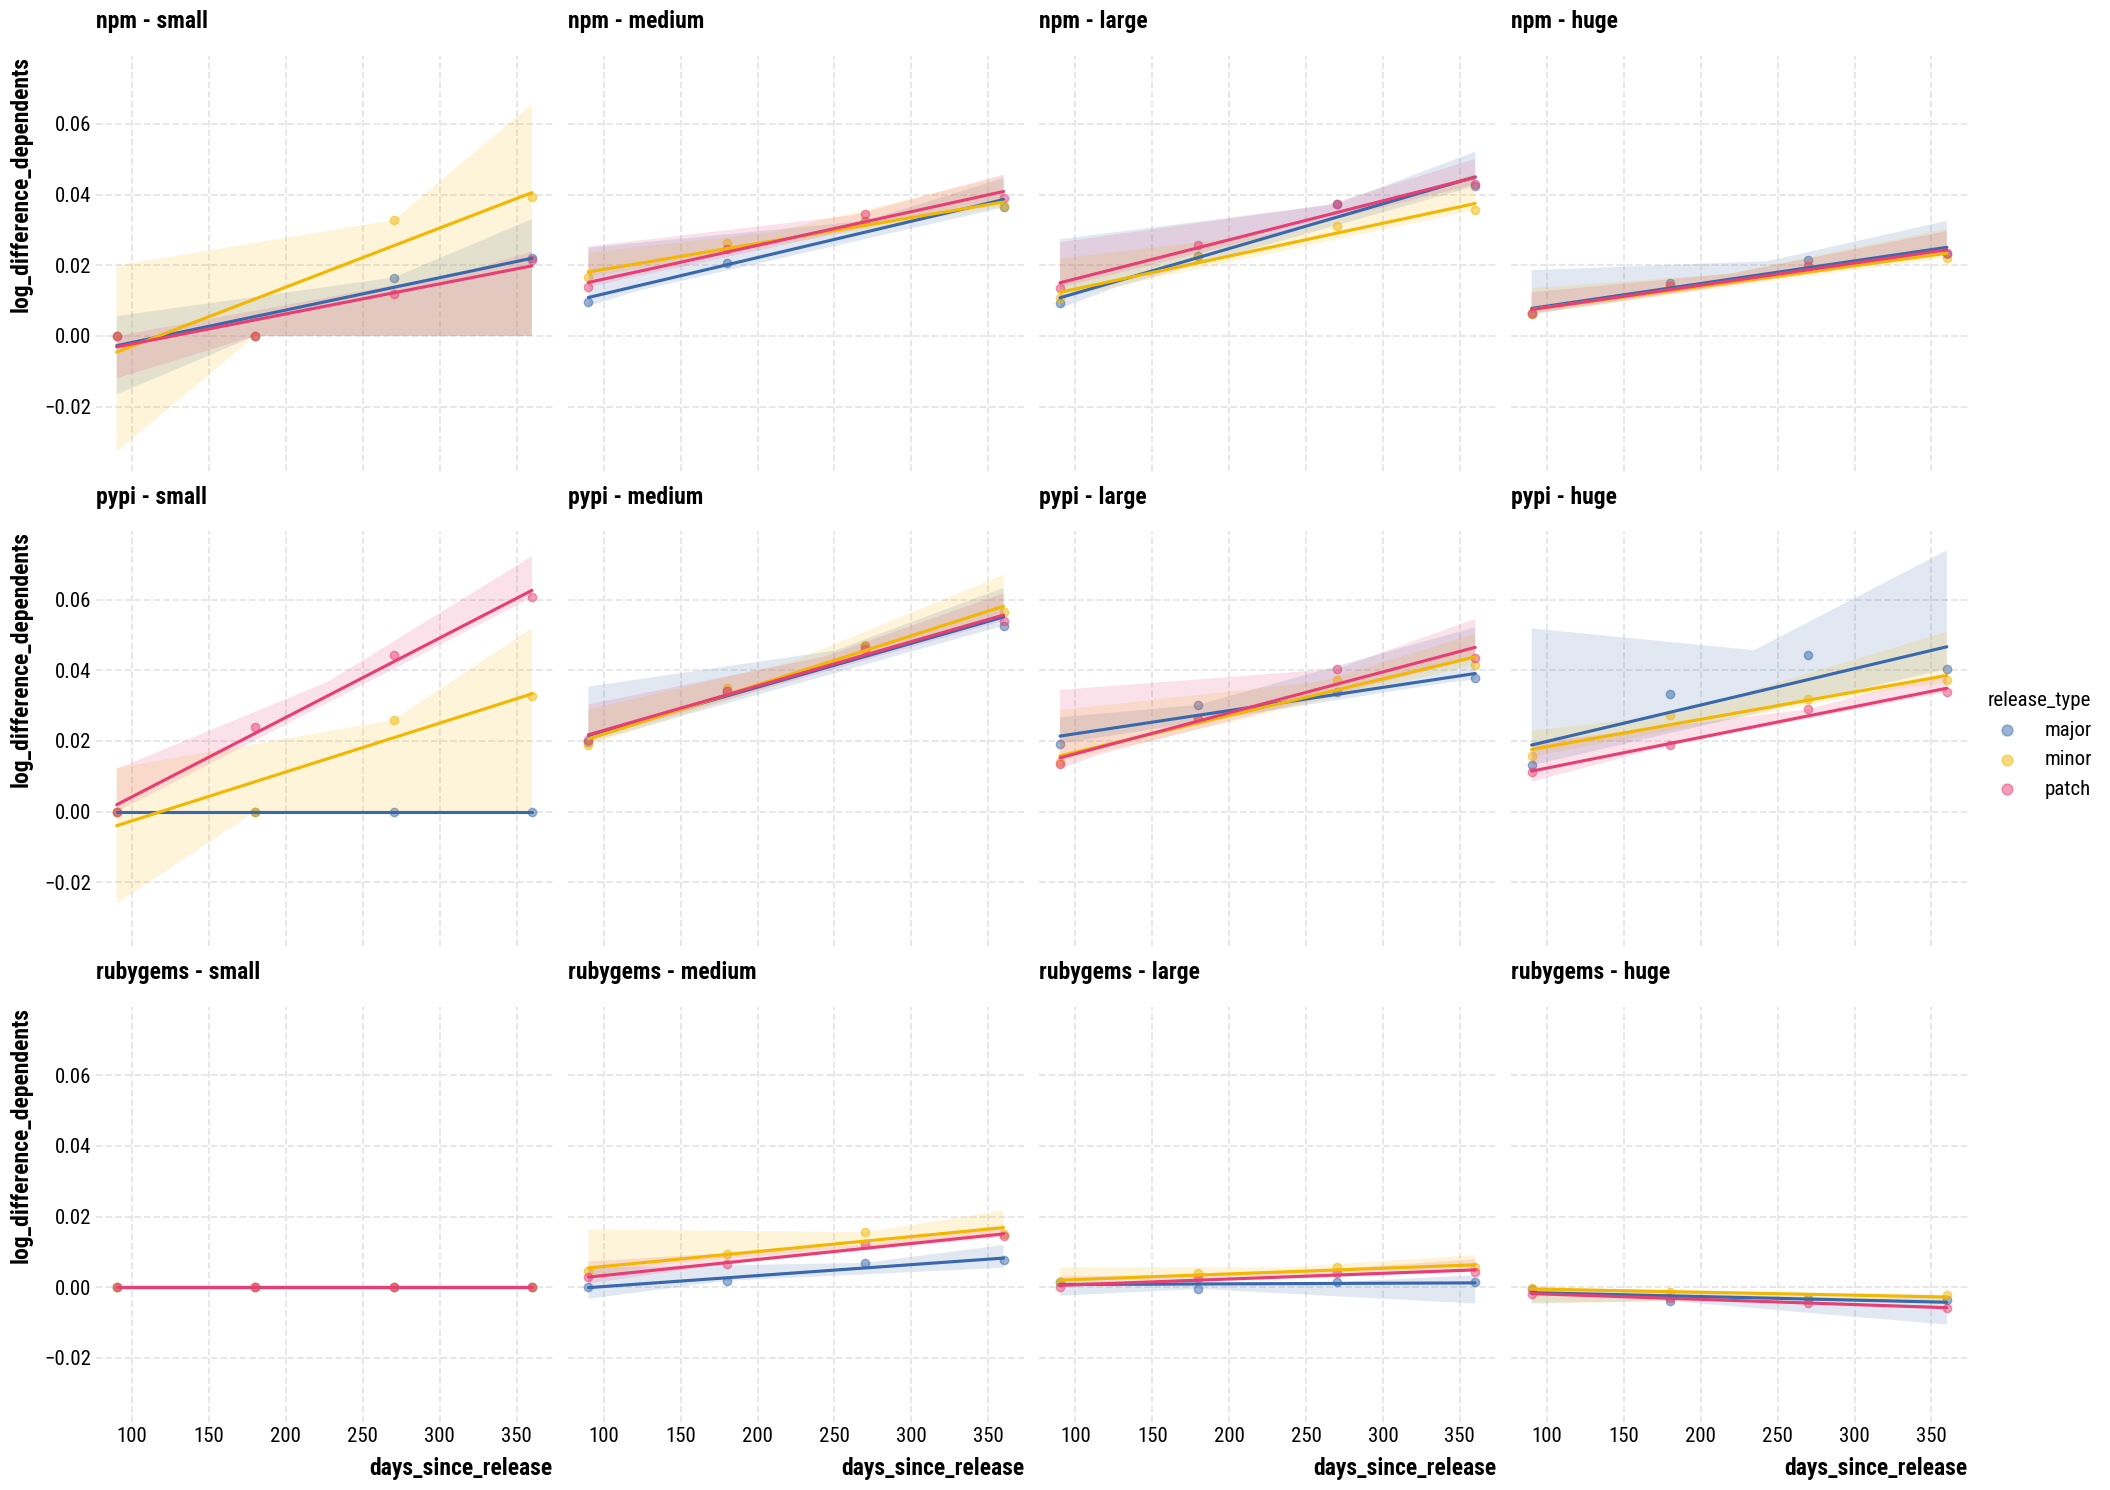

In [33]:
median_log_diff_dependents_initial_utilization = (
    log_diff_dependents_ecosystem_release_type.select(
        pl.col("ecosystem"),
        pl.col("release_type"),
        pl.col("num_dependents_bin"),
        pl.col("days_since_release"),
        pl.col("log_difference_dependents"),
    )
    .group_by(
        pl.all().exclude("log_difference_dependents"),
    )
    .quantile(0.5)
)

# Plot log difference dependents
g = sns.lmplot(
    data=median_log_diff_dependents_initial_utilization,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="num_dependents_bin",
    col_order=["small", "medium", "large", "huge"],
    scatter_kws={"alpha": 0.5},
)

g.set_titles("{row_name} - {col_name}")

#### Log Difference in Dependents by Package Ecosystem and Release Series

In [34]:
# g = sns.catplot(
#     data=log_diff_dependents_ecosystem_release_type.filter(
#         pl.col("days_since_release").eq(pl.lit(360)),
#         pl.col("release_type").is_in(["major", "minor", "patch"])
#     ),
#     x="release_type",
#     y="log_difference_dependents",
#     hue="release_type",
#     hue_order=["major", "minor", "patch"],
#     col="num_dependents_bin",
#     col_order=["small", "medium", "large", "huge"],
#     kind="box",
#     row="ecosystem",
#     row_order=["npm", "pypi", "rubygems"],
#     showfliers=False,
# )

# g.set_titles("{col_name} - {row_name}")

# Actually we want this as a table
# Columns are "ecosystem", "release_type", "small-mean", "medium-mean", "large-mean", "huge-mean"
# Group by ecosystem and release type, then calculate the mean for each num_dependents_bin
mean_dependents_per_ecosystem_release_type = (
    log_diff_dependents_ecosystem_release_type.filter(
        pl.col("days_since_release").eq(pl.lit(360)),
        # pl.col("release_type").is_in(["major", "minor", "patch"]),
        # remove inf and nan values
        pl.col("log_difference_dependents").is_null().not_(),
        pl.col("log_difference_dependents").is_infinite().not_(),
    )
    .group_by(["ecosystem", "release_type", "version_series"])
    .agg(
        pl.col("log_difference_dependents").mean().alias("mean_log_difference_dependents"),
        pl.col("log_difference_dependents").std().alias("std_log_difference_dependents"),
    )
    # Create column of rounded mean +- rounded std
    .with_columns(
        (
            pl.col("mean_log_difference_dependents").round(3).cast(pl.String)
            + pl.lit(" $\pm$ ")
            + pl.col("std_log_difference_dependents").round(3).cast(pl.String)
        ).alias("mean_std_log_difference_dependents"),
    )
    # zero major should be treated as major
    .with_columns(
        pl.when(pl.col("release_type").eq(pl.lit("zero-major")))
            .then(pl.lit("major"))
            .when(pl.col("release_type").eq(pl.lit("zero-minor")))
            .then(pl.lit("minor"))
            .otherwise(pl.col("release_type"))
            .alias("release_type"),
        pl.when(pl.col("version_series").eq(pl.lit("zero-ver")))
            .then(pl.lit("0 zero-ver"))
            .when(pl.col("version_series").eq(pl.lit("one-ver")))
            .then(pl.lit("1 one-ver"))
            .when(pl.col("version_series").eq(pl.lit("two-plus-ver")))
            .then(pl.lit("2 two-plus-ver"))
            .otherwise(pl.lit("unknown"))
            .alias("version_series_display"),
    )
    .pivot(
        index=["ecosystem", "version_series_display"],
        on="release_type",
        values="mean_std_log_difference_dependents",
    )
    .sort(by=["ecosystem", "version_series_display"])
    .select(
        pl.col("ecosystem").alias("Ecosystem"),
        pl.col("version_series_display").str.replace(r"\d+ ", "").alias("Version Series"),
        pl.col("major").alias("Log Diff. Major"),
        pl.col("minor").alias("Log Diff. Minor"),
        pl.col("patch").alias("Log Diff. Patch"),
    )
)

print(mean_dependents_per_ecosystem_release_type.to_pandas().to_latex(index=False))

\begin{tabular}{lllll}
\toprule
Ecosystem & Version Series & Log Diff. Major & Log Diff. Minor & Log Diff. Patch \\
\midrule
npm & zero-ver & 0.219 $\pm$ 0.525 & 0.204 $\pm$ 0.549 & NaN \\
npm & one-ver & 0.281 $\pm$ 0.724 & 0.152 $\pm$ 0.396 & 0.136 $\pm$ 0.416 \\
npm & two-plus-ver & 0.086 $\pm$ 0.32 & 0.092 $\pm$ 0.285 & 0.089 $\pm$ 0.304 \\
pypi & zero-ver & 0.101 $\pm$ 0.247 & 0.086 $\pm$ 0.259 & NaN \\
pypi & one-ver & 0.099 $\pm$ 0.266 & 0.091 $\pm$ 0.237 & 0.08 $\pm$ 0.224 \\
pypi & two-plus-ver & 0.065 $\pm$ 0.191 & 0.086 $\pm$ 0.209 & 0.123 $\pm$ 0.265 \\
rubygems & zero-ver & 0.125 $\pm$ 0.399 & 0.15 $\pm$ 0.435 & NaN \\
rubygems & one-ver & 0.136 $\pm$ 0.526 & 0.07 $\pm$ 0.288 & 0.061 $\pm$ 0.317 \\
rubygems & two-plus-ver & 0.05 $\pm$ 0.257 & 0.06 $\pm$ 0.254 & 0.047 $\pm$ 0.22 \\
\bottomrule
\end{tabular}



<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\p'
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_81154/2970686046.py:40: SyntaxWarning: invalid escape sequence '\p'
  + pl.lit(" $\pm$ ")


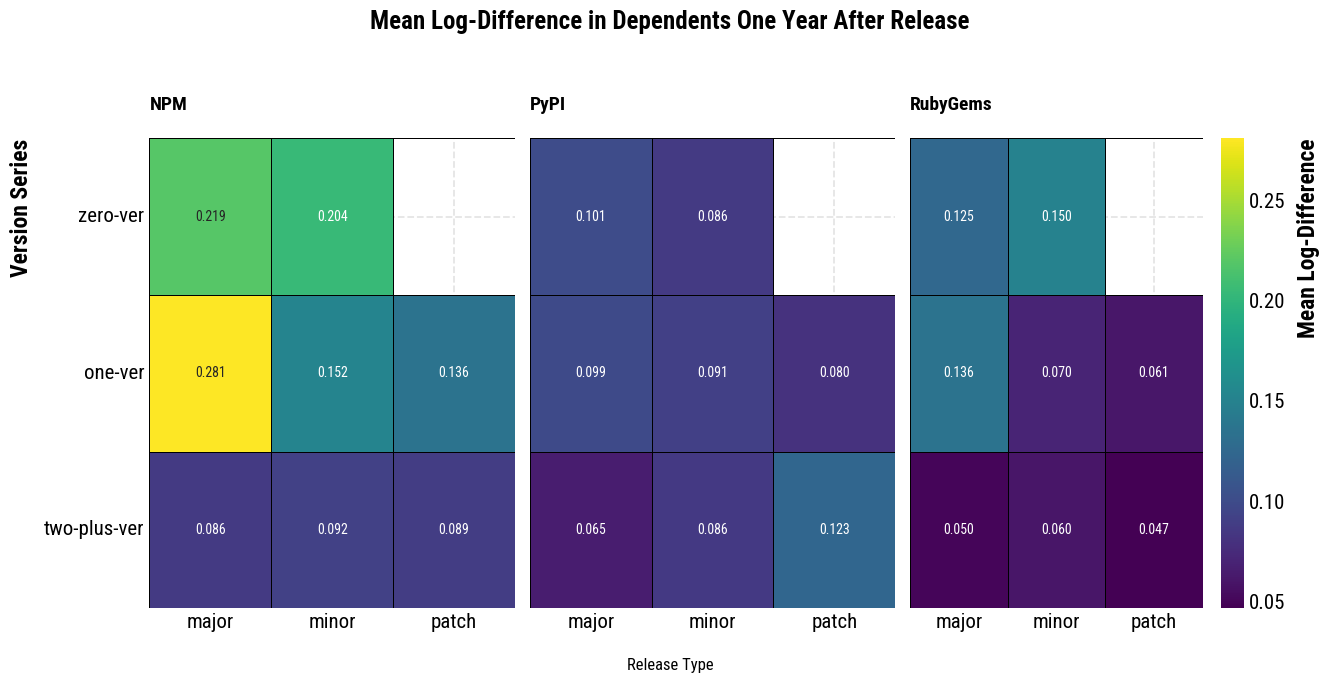

In [35]:
# --- Polars Data Preparation ---
base_data = (
    log_diff_dependents_ecosystem_release_type.filter(
        pl.col("days_since_release").eq(pl.lit(360)),
        pl.col("log_difference_dependents").is_null().not_(),
        pl.col("log_difference_dependents").is_infinite().not_(),
    )
    .group_by(["ecosystem", "version_series", "release_type"])
    .agg(
        pl.col("log_difference_dependents").mean().alias("mean_log_difference_dependents"),
    )
    .with_columns(
        pl.when(pl.col("release_type").eq(pl.lit("zero-major")))
            .then(pl.lit("major"))
            .when(pl.col("release_type").eq(pl.lit("zero-minor")))
            .then(pl.lit("minor"))
            .otherwise(pl.col("release_type"))
            .alias("release_type"),
        # Assign numeric prefixes and descriptive labels for correct sorting and display
        pl.when(pl.col("version_series").eq(pl.lit("zero-ver")))
            .then(pl.lit("0 zero-ver"))
            .when(pl.col("version_series").eq(pl.lit("one-ver")))
            .then(pl.lit("1 one-ver"))
            .when(pl.col("version_series").eq(pl.lit("two-plus-ver")))
            .then(pl.lit("2 two-plus-ver"))
            .otherwise(pl.lit("unknown"))
            .alias("version_series_display"), # New column for sorted and displayed order
    )
    .sort(by=["ecosystem", "version_series_display"]) # Sort by the new column
    .with_columns(
        # remove the numbers from the display column for better readability
        pl.col("version_series_display")
        .str.replace(r"^\d+ ", "")
        .alias("version_series_display"),
    )
    .fill_nan(pl.lit(0)) # Fill NaN values with 0 for heatmap compatibility
)


# Get unique ecosystems and their display names
ecosystem_map = {
    "npm": "NPM",
    "pypi": "PyPI",
    "rubygems": "RubyGems"
}
ecosystems_sorted = sorted(ecosystem_map.keys()) # Ensure consistent order

# Determine a common color scale range
min_val = base_data["mean_log_difference_dependents"].min()
max_val = base_data["mean_log_difference_dependents"].max()

# --- Heatmap Generation (Subplots) ---
fig, axes = plt.subplots(1, len(ecosystems_sorted), figsize=(4.5 * len(ecosystems_sorted), 6.5), sharey=True)

if len(ecosystems_sorted) == 1:
    axes = [axes] # Ensure axes is iterable even if only one subplot

for i, ecosystem_key in enumerate(ecosystems_sorted):
    ecosystem_display_name = ecosystem_map[ecosystem_key]

    # Filter data for the current ecosystem
    current_ecosystem_data = base_data.filter(pl.col("ecosystem").eq(ecosystem_key))

    # Pivot for the heatmap
    heatmap_df = (
        current_ecosystem_data.pivot(
            index="version_series_display", # Use the sorted display column as index
            on="release_type",
            values="mean_log_difference_dependents",
        )
        .select(["version_series_display", "major", "minor", "patch"]) # Ensure column order
        .to_pandas()
    )
    heatmap_df = heatmap_df.set_index("version_series_display")

    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=.5,
        linecolor="black",
        cbar=True if i == len(ecosystems_sorted) - 1 else False,
        ax=axes[i],
        vmin=min_val,
        vmax=max_val,
        cbar_kws={'label': 'Mean Log-Difference'}
    )
    axes[i].set_title(ecosystem_display_name, fontsize=14) # Smaller title font
    axes[i].set_xlabel('') # Remove individual x-labels
    if i == 0:
        axes[i].set_ylabel('Version Series')
    else:
        axes[i].set_ylabel('')
    axes[i].tick_params(axis='y', rotation=0)

# Overall Title
plt.suptitle('Mean Log-Difference in Dependents One Year After Release', y=1.03, fontsize=18, weight='bold') # Bigger, bold title

# Overall X-axis label, positioned manually for "left-alignment" look
fig.text(0.5, 0.01, 'Release Type', ha='center', va='bottom', fontsize=12) # Adjust x,y for positioning

plt.tight_layout(rect=[0, 0.05, 1, 0.98]) # Adjust layout to make room for suptitle and overall xlabel
plt.show()

In [36]:
results = {}

def compute_anova_and_post_hocs_for_ecosystem(
    data: pl.DataFrame,
    ecosystem: str,
) -> None:
    for group in data.select("version_series").unique()["version_series"]:
        # One way ANOVA for ecosystem and group
        distributions = {
            release_type: data.filter(pl.col("ecosystem").eq(pl.lit(ecosystem)))
            .filter(pl.col("release_type").eq(pl.lit(release_type)))
            .filter(pl.col("version_series").eq(pl.lit(group)))
            .select(pl.col("log_difference_dependents"))
            .get_column("log_difference_dependents")
            .to_numpy()
            for release_type in ["major", "minor", "patch"]
        }

        overall_group_result = f_oneway(*distributions.values())
        if overall_group_result.pvalue < 0.05:
            overall_group_result_str = "+"
        else:
            overall_group_result_str = ""

        group_results_key = f"{group}{overall_group_result_str}"

        # Conduct pairwise t-tests
        for release_type1, release_type2 in combinations(distributions.keys(), 2):
            post_hoc_result = ttest_ind(
                distributions[release_type1],
                distributions[release_type2],
            )

            # Calc means, stds, and counts
            dist_1_mean = round(distributions[release_type1].mean(), 3)
            dist_1_std = round(distributions[release_type1].std(), 3)
            dist_1_count = len(distributions[release_type1])
            dist_2_mean = round(distributions[release_type2].mean(), 3)
            dist_2_std = round(distributions[release_type2].std(), 3)
            dist_2_count = len(distributions[release_type2])

            if release_type1 == "major" and release_type2 == "minor":
                significant_str = "*"
            elif release_type1 == "major" and release_type2 == "patch":
                significant_str = "^"
            elif release_type1 == "minor" and release_type2 == "patch":
                significant_str = "#"

            if post_hoc_result.pvalue < 0.05:
                post_hoc_result_str = f" {significant_str}"
            else:
                post_hoc_result_str = ""

            # Setup results
            if ecosystem not in results:
                results[ecosystem] = {}
            if group_results_key not in results[ecosystem]:
                results[ecosystem][group_results_key] = {}

            # Store results
            if release_type1 not in results[ecosystem][group_results_key]:
                results[ecosystem][group_results_key][release_type1] = (
                    f"{dist_1_mean}±{dist_1_std} ({dist_1_count}){post_hoc_result_str}"
                )
            else:
                results[ecosystem][group_results_key][release_type1] += (
                    f"{post_hoc_result_str}"
                )
        
            # Store results
            if release_type2 not in results[ecosystem][group_results_key]:
                results[ecosystem][group_results_key][release_type2] = (
                    f"{dist_2_mean}±{dist_2_std} ({dist_2_count}){post_hoc_result_str}"
                )
            else:
                results[ecosystem][group_results_key][release_type2] += (
                    f"{post_hoc_result_str}"
                )

# Compute ANOVA and post hocs for each ecosystem
for ecosystem in ["npm", "pypi", "rubygems"]:
    compute_anova_and_post_hocs_for_ecosystem(
        data=anova_data.with_columns(
            pl.when(pl.col("release_type").eq(pl.lit("zero-major")))
                .then(pl.lit("major"))
                .when(pl.col("release_type").eq(pl.lit("zero-minor")))
                .then(pl.lit("minor"))
                .otherwise(pl.col("release_type"))
                .alias("release_type"),
        ),
        ecosystem=ecosystem,
    )

# Unpack to table of results
# columns are:
#  - ecosystem
#  - group
#  - major
#  - minor
#  - patch
results_table = []
for ecosystem, groups in results.items():
    for group, release_types in groups.items():
        row = {
            "ecosystem": ecosystem,
            "group": group,
        }
        row.update(release_types)
        results_table.append(row)

results_table_df = pl.DataFrame(results_table)
results_table_df

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_81154/3143301601.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  overall_group_result = f_oneway(*distributions.values())
/Users/evamaxfield/micromamba/envs/dg-uoi/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_81154/3143301601.py:38: RuntimeWarning: Mean of empty slice.
  dist_2_mean = round(distributions[release_type2].mean(), 3)
/Users/evamaxfield/micromamba/envs/dg-uoi/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/evamaxfield/micromamba/envs/dg-uoi/lib/python3.12/site-

ecosystem,group,major,minor,patch
str,str,str,str,str
"""npm""","""zero-ver""","""0.219±0.525 (9907) *""","""0.204±0.549 (37010) *""","""nan±nan (0)"""
"""npm""","""one-ver+""","""0.281±0.723 (1250) * ^""","""0.152±0.396 (13604) * #""","""0.136±0.416 (43310) ^ #"""
"""npm""","""two-plus-ver""","""0.086±0.32 (15431) *""","""0.092±0.285 (39528) *""","""0.089±0.304 (115849)"""
"""pypi""","""zero-ver""","""0.101±0.247 (5202) *""","""0.086±0.259 (15791) *""","""nan±nan (0)"""
"""pypi""","""one-ver+""","""0.099±0.265 (369)""","""0.091±0.236 (3418) #""","""0.08±0.224 (10746) #"""
"""pypi""","""two-plus-ver+""","""0.065±0.191 (1392) * ^""","""0.086±0.209 (5763) * #""","""0.123±0.265 (13809) ^ #"""
"""rubygems""","""zero-ver""","""0.125±0.399 (1748) *""","""0.15±0.434 (3038) *""","""nan±nan (0)"""
"""rubygems""","""two-plus-ver""","""0.05±0.257 (774)""","""0.06±0.254 (2780) #""","""0.047±0.22 (4920) #"""
"""rubygems""","""one-ver+""","""0.136±0.525 (225) * ^""","""0.07±0.288 (1715) *""","""0.061±0.317 (3395) ^"""


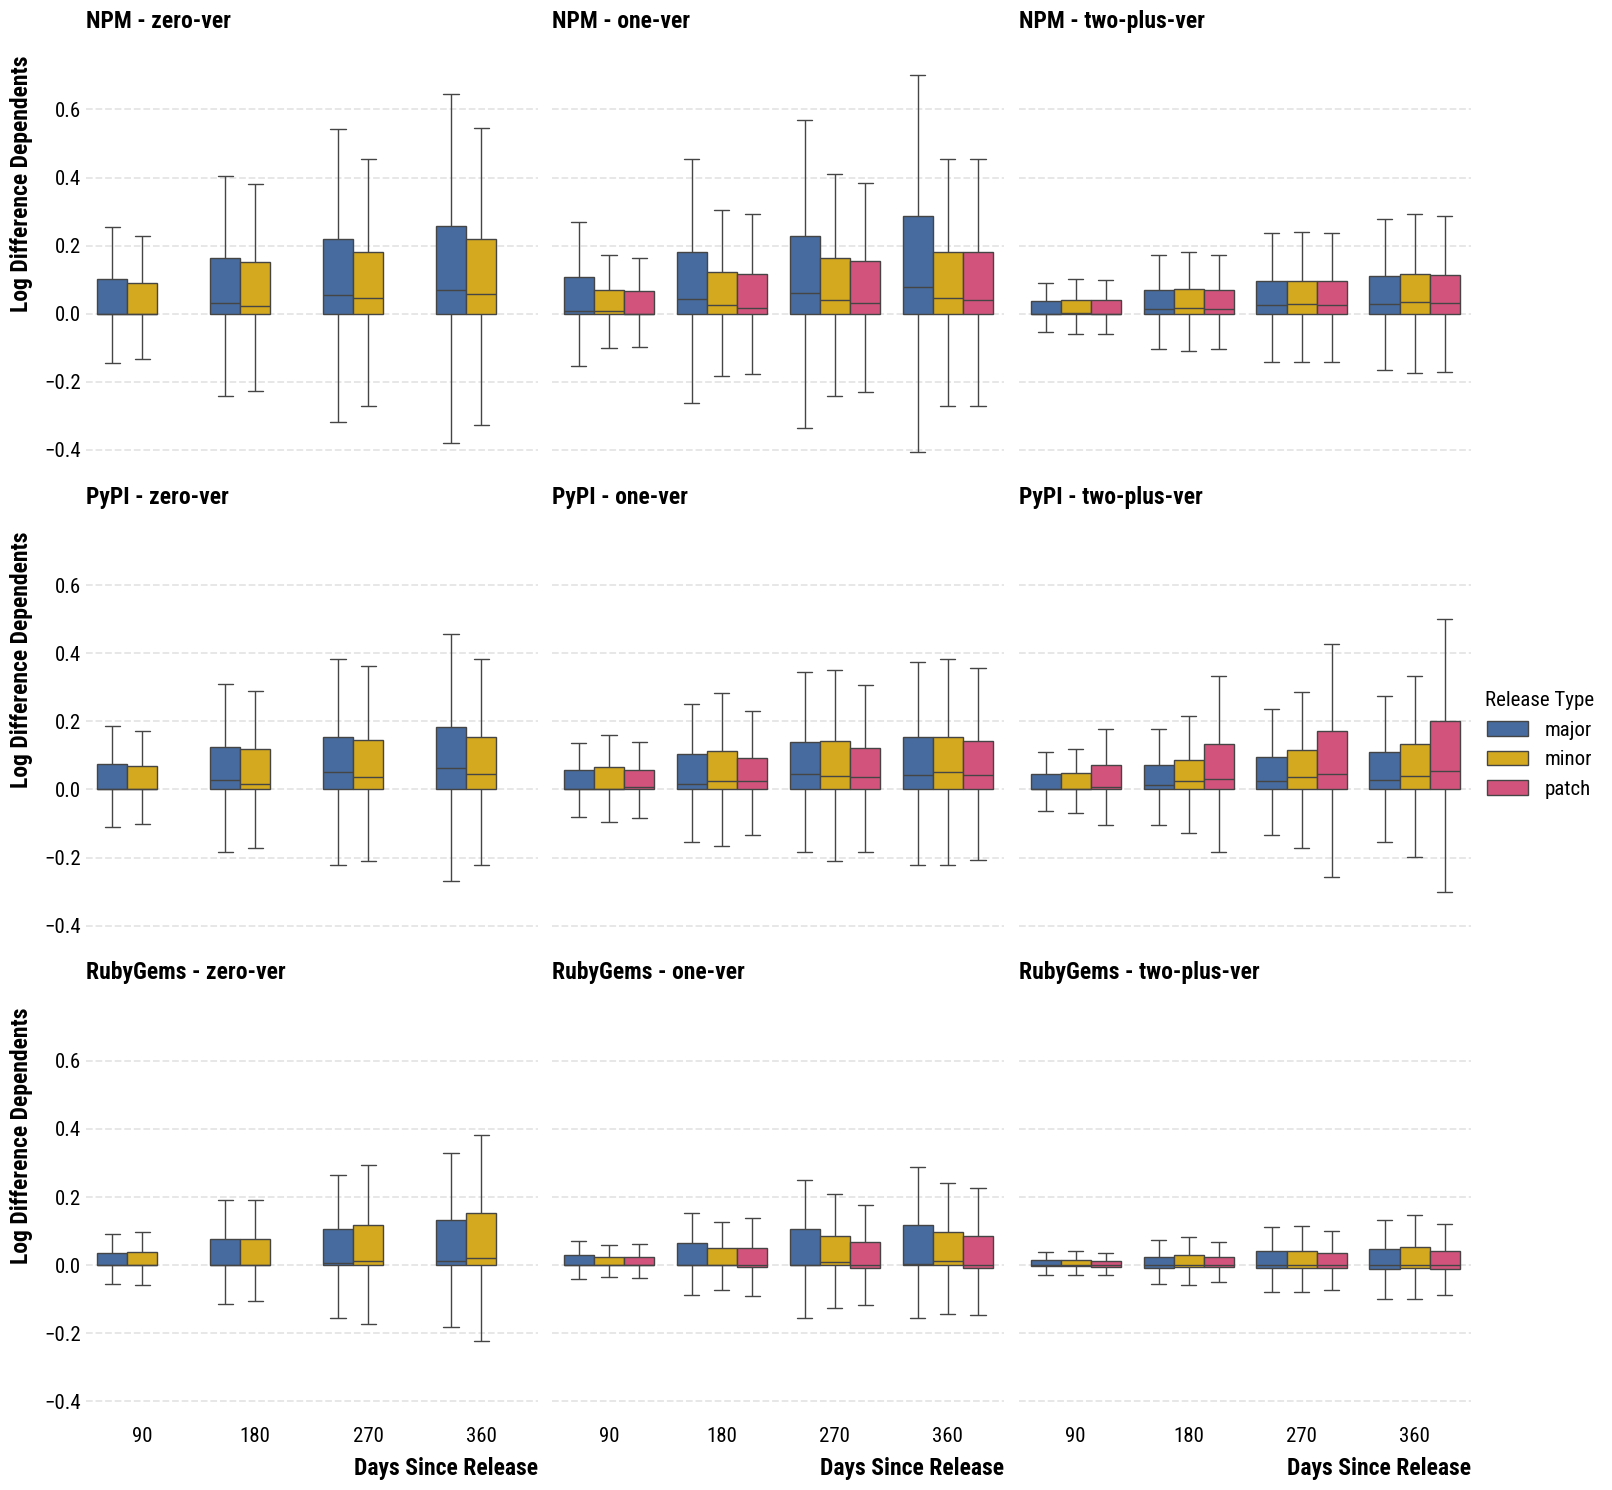

In [37]:
# Replace zero-ver release types
log_diff_dependents_ecosystem_release_type_replaced_zero_ver = (
    log_diff_dependents_ecosystem_release_type.select(
        pl.all().exclude("release_type"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
    )
)

# Plot log difference dependents
g = sns.catplot(
    data=log_diff_dependents_ecosystem_release_type_replaced_zero_ver.with_columns(
        pl.col("log_difference_dependents").alias("Log Difference Dependents"),
        pl.col("days_since_release").alias("Days Since Release"),
        pl.col("release_type").alias("Release Type"),
        pl.when(pl.col("ecosystem").eq(pl.lit("npm")))
        .then(pl.lit("NPM"))
        .when(pl.col("ecosystem").eq(pl.lit("pypi")))
        .then(pl.lit("PyPI"))
        .when(pl.col("ecosystem").eq(pl.lit("rubygems")))
        .then(pl.lit("RubyGems"))
        .otherwise(pl.lit("Unknown Ecosystem"))
        .alias("ecosystem"),
    ),
    x="Days Since Release",
    y="Log Difference Dependents",
    hue="Release Type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["NPM", "PyPI", "RubyGems"],
    col="version_series",
    col_order=["zero-ver", "one-ver", "two-plus-ver"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

In [38]:
def compute_anova_and_post_hocs_for_ecosystem(
    data: pl.DataFrame,
    ecosystem: str,
) -> None:
    for group in data.select("version_series").unique()["version_series"]:
        print()
        print(f"Working on group: {group}")
        print()

        # One way ANOVA for ecosystem and group
        distributions = {
            release_type: data.filter(pl.col("ecosystem").eq(pl.lit(ecosystem)))
            .filter(pl.col("release_type").eq(pl.lit(release_type)))
            .select(pl.col("log_difference_dependents"))
            .get_column("log_difference_dependents")
            .to_numpy()
            for release_type in ["major", "minor", "patch"]
        }

        result = f_oneway(*distributions.values())
        print(result)

        if result.pvalue < 0.05:
            print("Distributions are significantly different")
            print()

            # Conduct pairwise t-tests
            for release_type1, release_type2 in combinations(distributions.keys(), 2):
                post_hoc_result = ttest_ind(
                    distributions[release_type1],
                    distributions[release_type2],
                )

                if post_hoc_result.pvalue < 0.05:
                    print(release_type1, release_type2, post_hoc_result)
                    print(
                        release_type1,
                        round(distributions[release_type1].mean(), 3),
                        round(distributions[release_type1].std(), 3),
                    )
                    print(
                        release_type2,
                        round(distributions[release_type2].mean(), 3),
                        round(distributions[release_type2].std(), 3),
                    )
                else:
                    print(
                        f"{release_type1} and {release_type2} are not significantly different"
                    )
                
                print()


# Compute ANOVA and post hocs for each ecosystem
for ecosystem in ["npm", "pypi", "rubygems"]:
    print(f"ECOSYSTEM: {ecosystem}")
    compute_anova_and_post_hocs_for_ecosystem(
        data=anova_data,
        ecosystem=ecosystem,
    )
    print()
    print("-" * 80)

ECOSYSTEM: npm

Working on group: two-plus-ver

F_onewayResult(statistic=np.float64(5.888694306384211), pvalue=np.float64(0.0027710114963005674))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(-2.2040631911153414), pvalue=np.float64(0.027523151602229925), df=np.float64(69811.0))
major 0.101 0.37
minor 0.107 0.318

major and patch are not significantly different

minor patch TtestResult(statistic=np.float64(3.3548829192460916), pvalue=np.float64(0.0007941247848378115), df=np.float64(212289.0))
minor 0.107 0.318
patch 0.102 0.339


Working on group: one-ver

F_onewayResult(statistic=np.float64(5.888694306384211), pvalue=np.float64(0.0027710114963005674))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(-2.2040631911153414), pvalue=np.float64(0.027523151602229925), df=np.float64(69811.0))
major 0.101 0.37
minor 0.107 0.318

major and patch are not significantly different

minor patch TtestResult(statistic=np.f

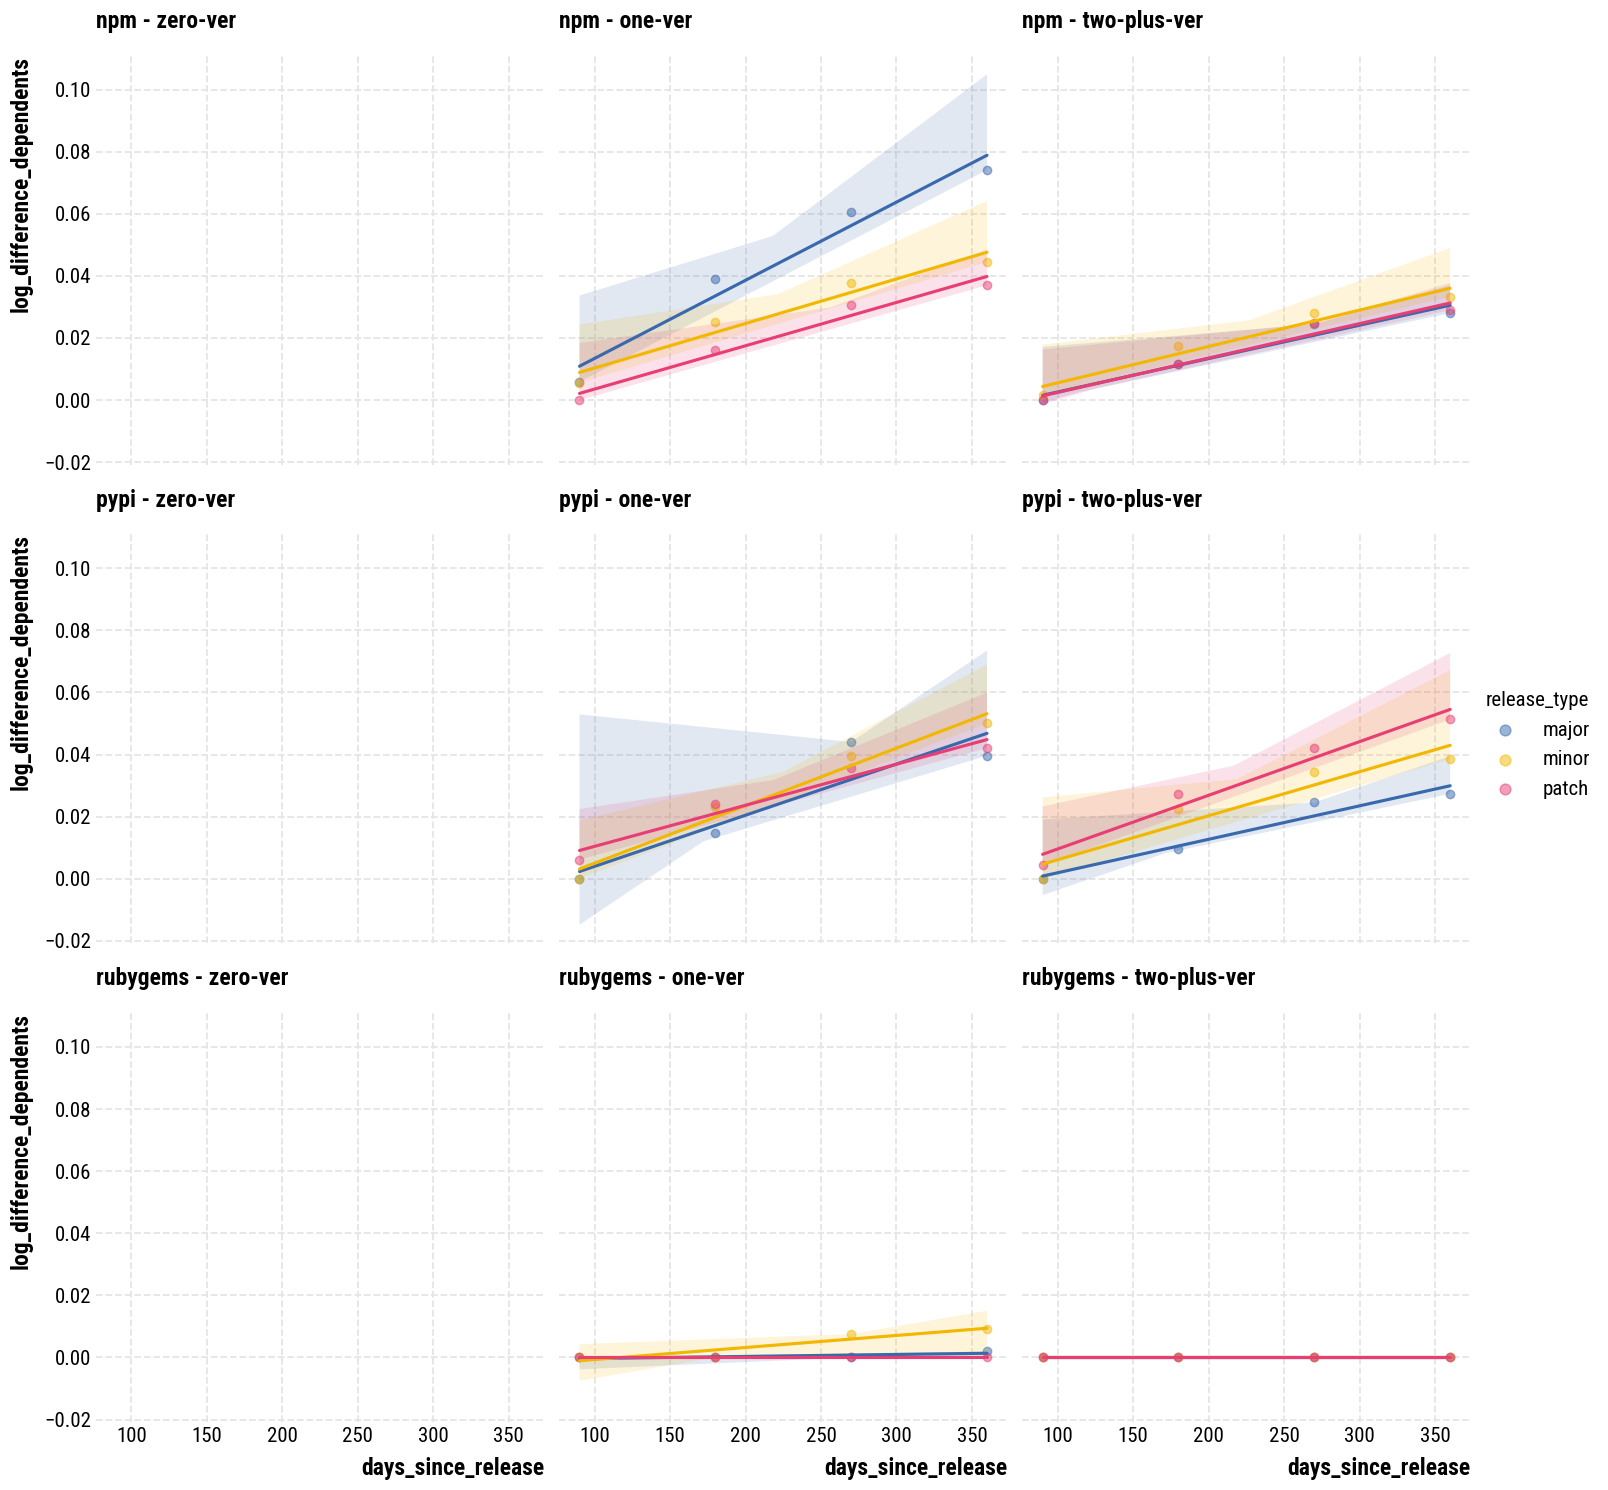

In [39]:
median_log_diff_dependents_release_series = (
    log_diff_dependents_ecosystem_release_type.select(
        pl.col("ecosystem"),
        pl.col("release_type"),
        pl.col("version_series"),
        pl.col("days_since_release"),
        pl.col("log_difference_dependents"),
    )
    .group_by(
        pl.all().exclude("log_difference_dependents"),
    )
    .quantile(0.5)
)

# Plot log difference dependents
g = sns.lmplot(
    data=median_log_diff_dependents_release_series,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="version_series",
    col_order=["zero-ver", "one-ver", "two-plus-ver"],
    scatter_kws={"alpha": 0.5},
)

g.set_titles("{row_name} - {col_name}")